# For this notebook, we're going to re-do all of the analyses from scratch to see how robust our results are to changing data assumptions  
(e.g. horizontal and amacrine space constants)

In [161]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

David's 1721 receptive field dataset

In [5]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

### Remove duplicates

In [6]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

126it [00:00, 208.38it/s]
2it [00:00, 11491.24it/s]
253it [00:02, 114.48it/s]
772it [00:21, 36.37it/s] 
2it [00:00, 10894.30it/s]
321it [00:03, 88.71it/s] 
249it [00:02, 115.07it/s]
28it [00:00, 1024.62it/s]
2it [00:00, 9078.58it/s]


In [7]:
sum([len(receptive_fields[k]) for k in receptive_fields.keys()]) - sum([len(receptive_fields[k]) for k in ['horizontal',
                                                                                                           'amacrine',
                                                                                                          'bipolar']])

1382

### Compute projective fields

In [8]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [9]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [13]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [14]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


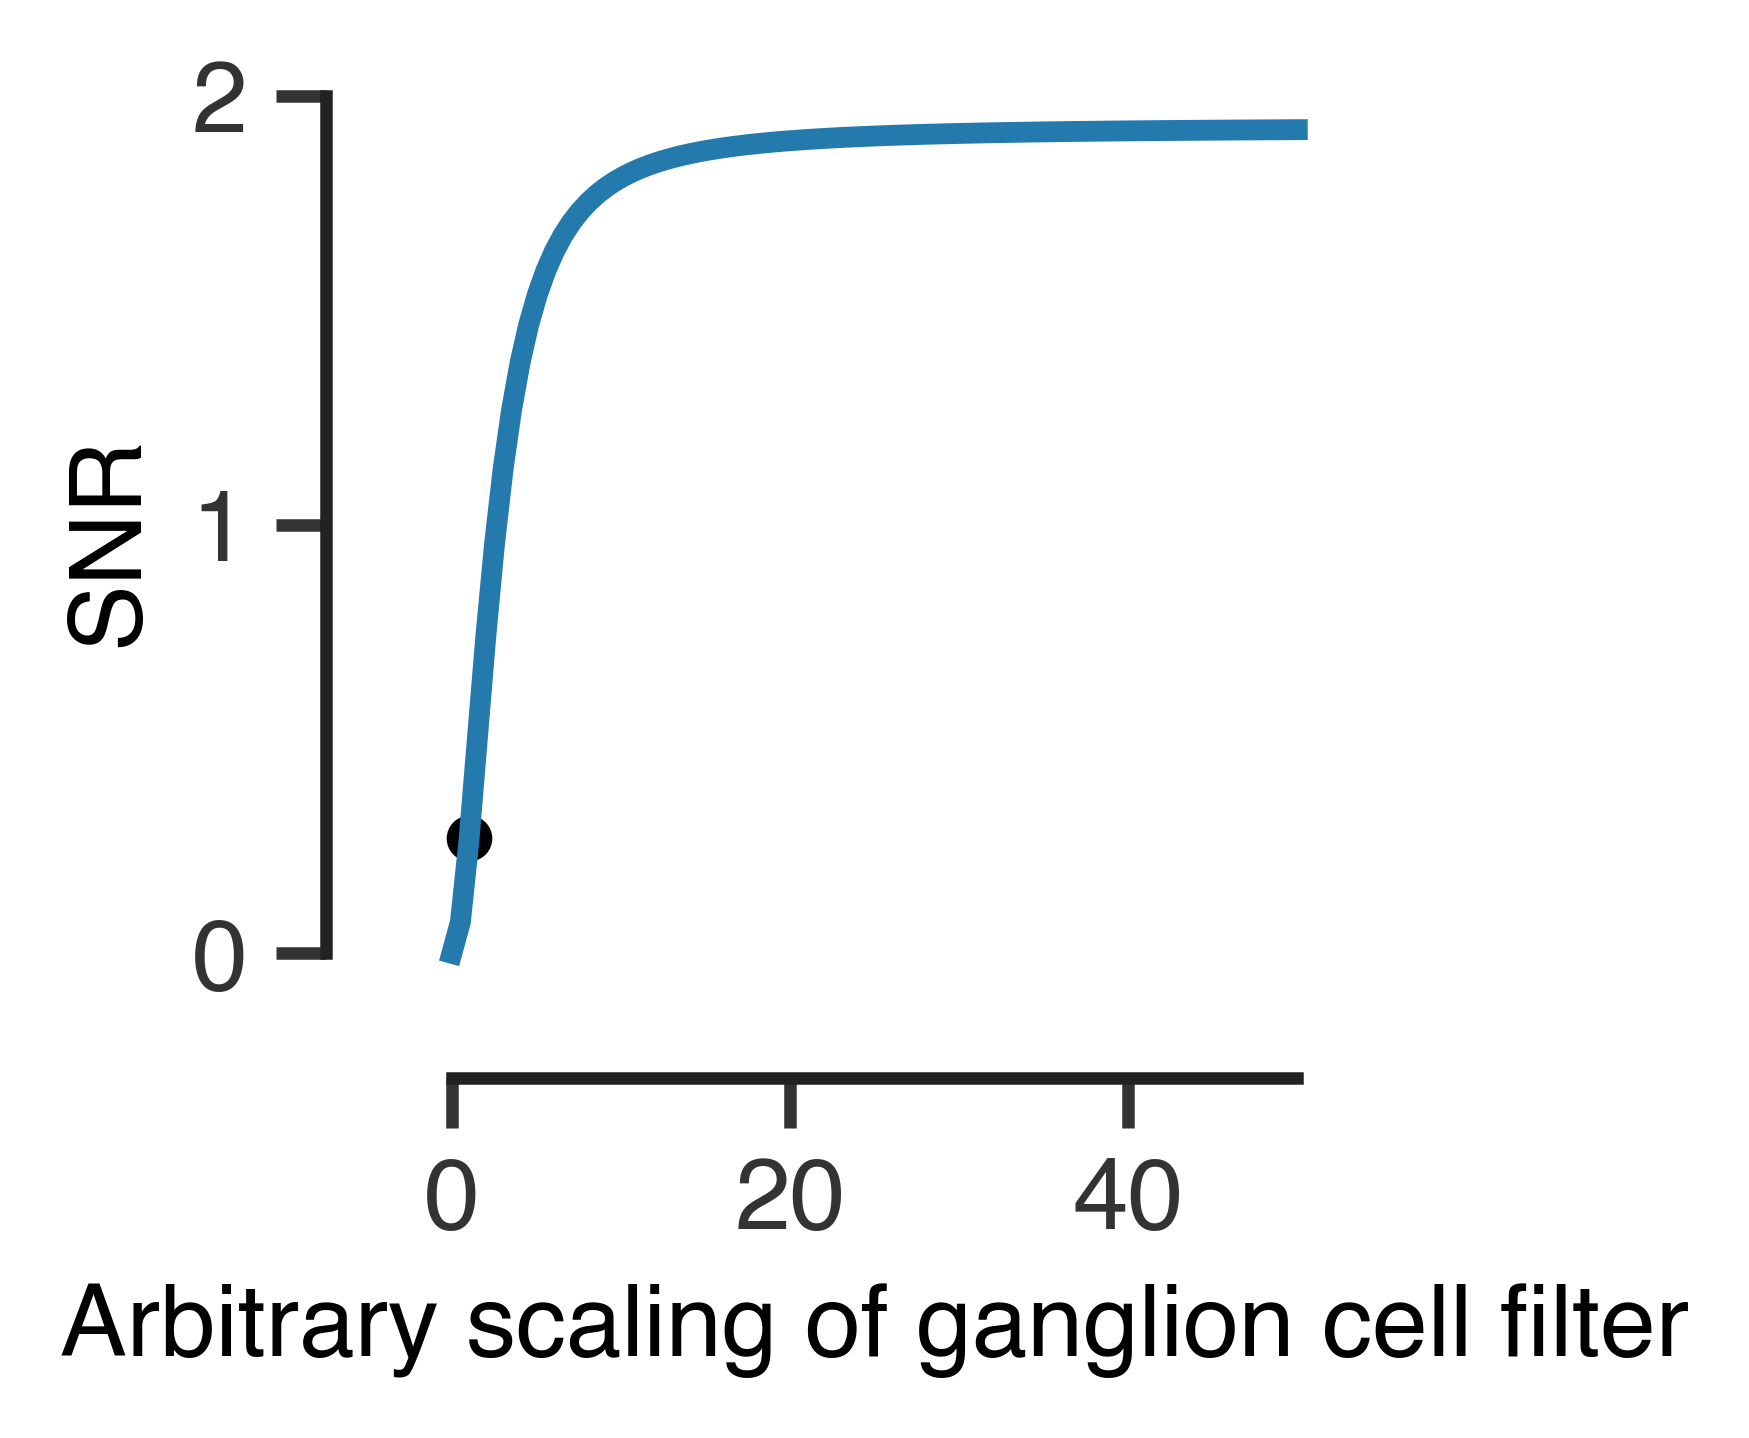

In [17]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

our_snr = get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

plt.scatter(filt_const_opt.x, our_snr, s=20, color='k')

### Ideal filter

In [18]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.13230163623e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [19]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

### Just a simple difference of Gaussians fit to get the initialization point for center width, and the mean center width to find the ideal fit

Get center widths for each celltype

In [20]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [21]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [22]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

159it [00:31,  7.62it/s]
28it [00:11,  1.00s/it]
58it [00:14,  4.64it/s]
772it [01:48,  7.11it/s]
148it [01:05,  1.76it/s]
217it [00:51,  4.73it/s]


In [23]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 1 in fast_on
couldn't fit 13 in slow_off
couldn't fit 4 in fast_off_adapting
couldn't fit 3 in fast_off_sensitizing
couldn't fit 4 in medium_off_adapting
couldn't fit 3 in ganglion


Plot the average profile across celltypes

In [24]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [25]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0456543257003039,
 'fast_on': 2.1703662900605498,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.555772399380934,
 'slow_off': 1.5248731503974167}

Bar charts to visualize diversity

## Generate info maps

In [26]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [27]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:31,  4.77it/s]
150it [00:33,  4.43it/s]
150it [00:34,  4.77it/s]
150it [00:33,  4.63it/s]
150it [00:33,  4.50it/s]
150it [00:32,  4.66it/s]


## Fit cells to rf_model

In [28]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

In [29]:
info_maps.keys()

dict_keys(['fast_on', 'slow_off', 'fast_off_adapting', 'fast_off_sensitizing', 'medium_off_adapting', 'ganglion'])

## Load receptive field model fits

In [30]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [31]:
# fits = np.load('fits_3_23.npy').item()
# all_params = np.load('params_3_23.npy').item()
# variances = np.load('variances_3_23.npy').item()
# mean_squared_errors = np.load('mse_3_23.npy').item()
# abs_errors = np.load('abserrs_3_23.npy').item()

In [ ]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    horz_weight = sigmoid(horz_weight)
    center_weight = sigmoid(center_weight)

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                # add regularization to ama_pos and horz_pos
                return sum(abs(normed_rf - rf)**2) #+ 0.005*(ama_pos**2 + horz_pos**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.randn(2)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (None,None), (None,None)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # translate hw and cw params back into [0,1] range
            x = sigmoid(popt.x[-2:])

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
3it [01:12, 22.98s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
8it [02:54, 19.92s/it]

PC1 has explained variance 89.24% percent for all cells
PC1 has explained variance 99.97% percent for fast_on
PC1 has explained variance 99.62% percent for slow_off
PC1 has explained variance 99.74% percent for fast_off_adapting
PC1 has explained variance 99.93% percent for fast_off_sensitizing
PC1 has explained variance 99.65% percent for medium_off_adapting
PC1 has explained variance 99.49% percent for ganglion


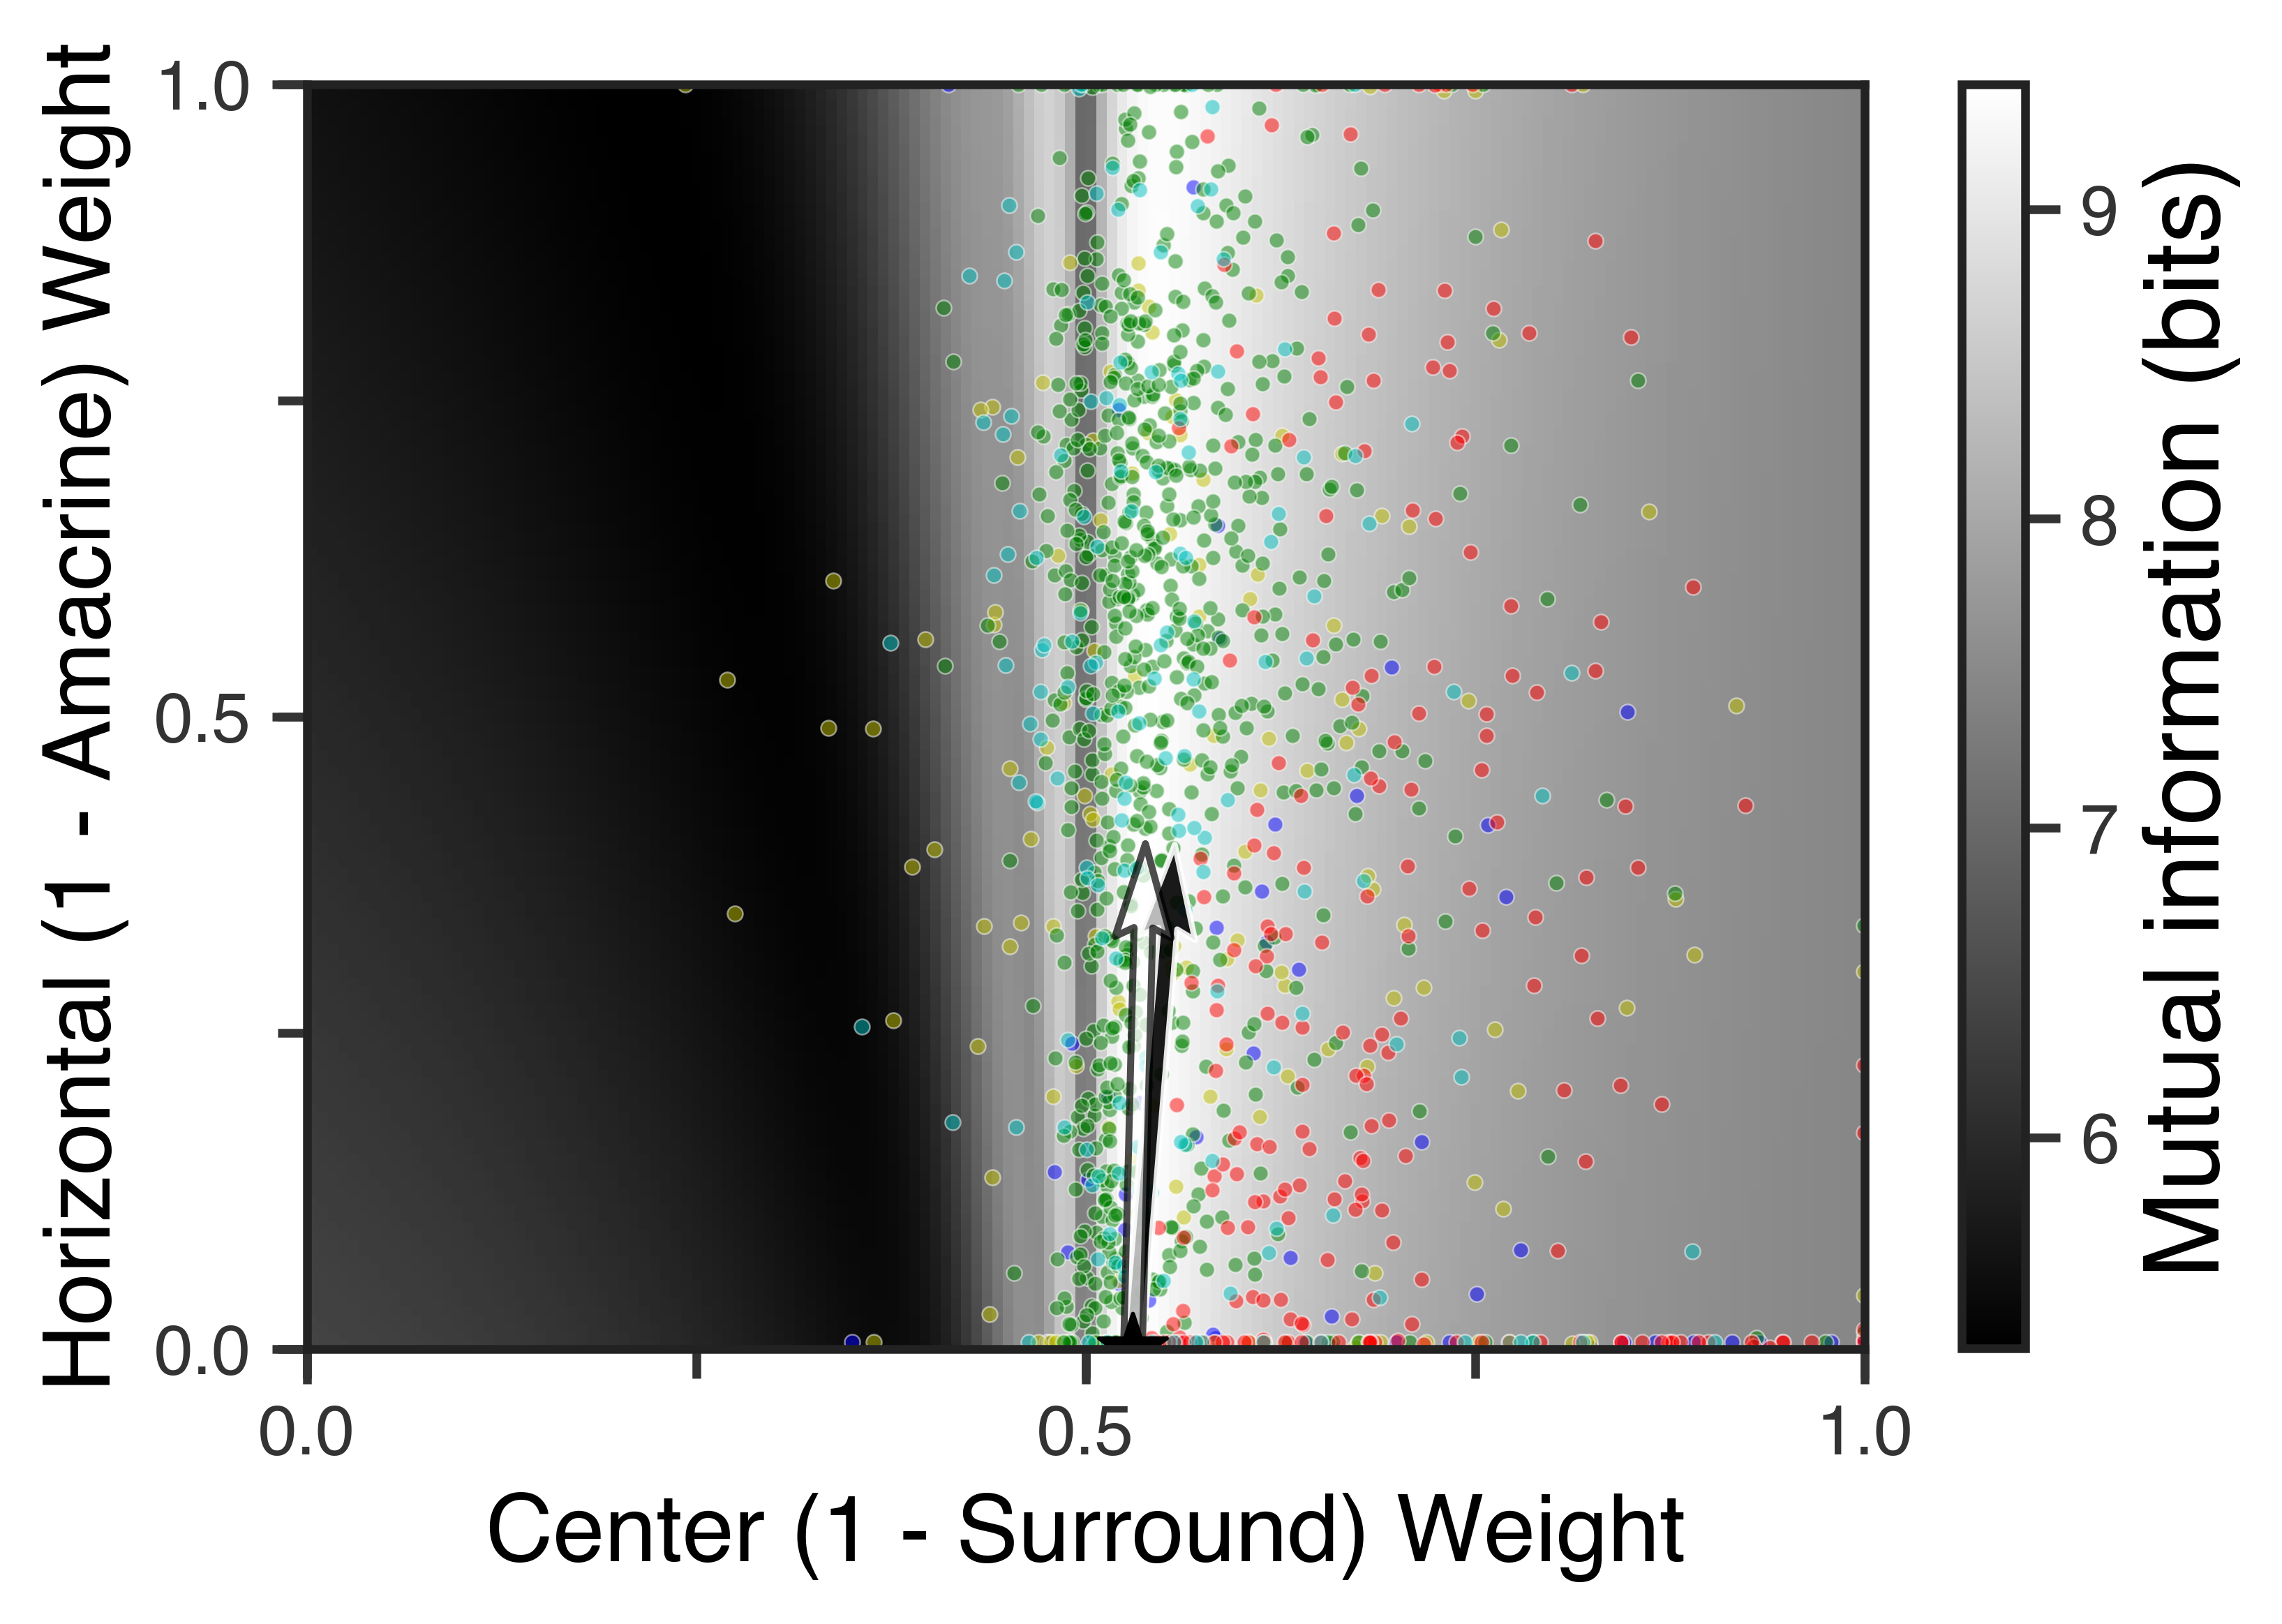

In [37]:
global_celltype = 'medium_off_adapting' #'fast_off_adapting'
point_size = 7 #10
min_info = np.min(info_maps[global_celltype])
max_info = np.max(info_maps[global_celltype])
empirical_ideal_indices = np.unravel_index(np.argmax(info_maps[global_celltype]), info_maps[global_celltype].shape)
empirical_ideal = [horz_weights[empirical_ideal_indices[0]], center_weights[empirical_ideal_indices[1]]]

########## for quivers #########
all_fits = []
for celltype in fits.keys():
    all_fits.extend(fits[celltype])
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.97*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)
############ end quivers ###########

plt.imshow(info_maps[global_celltype], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
cbar.set_ticks([6,7,8,9])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=point_size, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
#     plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
#                adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
#                c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


# plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
#           alpha=0.9)
# plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
#           alpha=0.7, width=.012, linewidth=1.2)
# plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

plt.quiver(empirical_ideal[1], empirical_ideal[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(empirical_ideal[1], empirical_ideal[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(empirical_ideal[1], empirical_ideal[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)


# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# #plt.savefig('Figures for Steve IV.png')

In [38]:
empirical_ideal_indices

(0, 79)

In [39]:
empirical_ideal

[0.0, 0.53020134228187921]

### Quality of fit

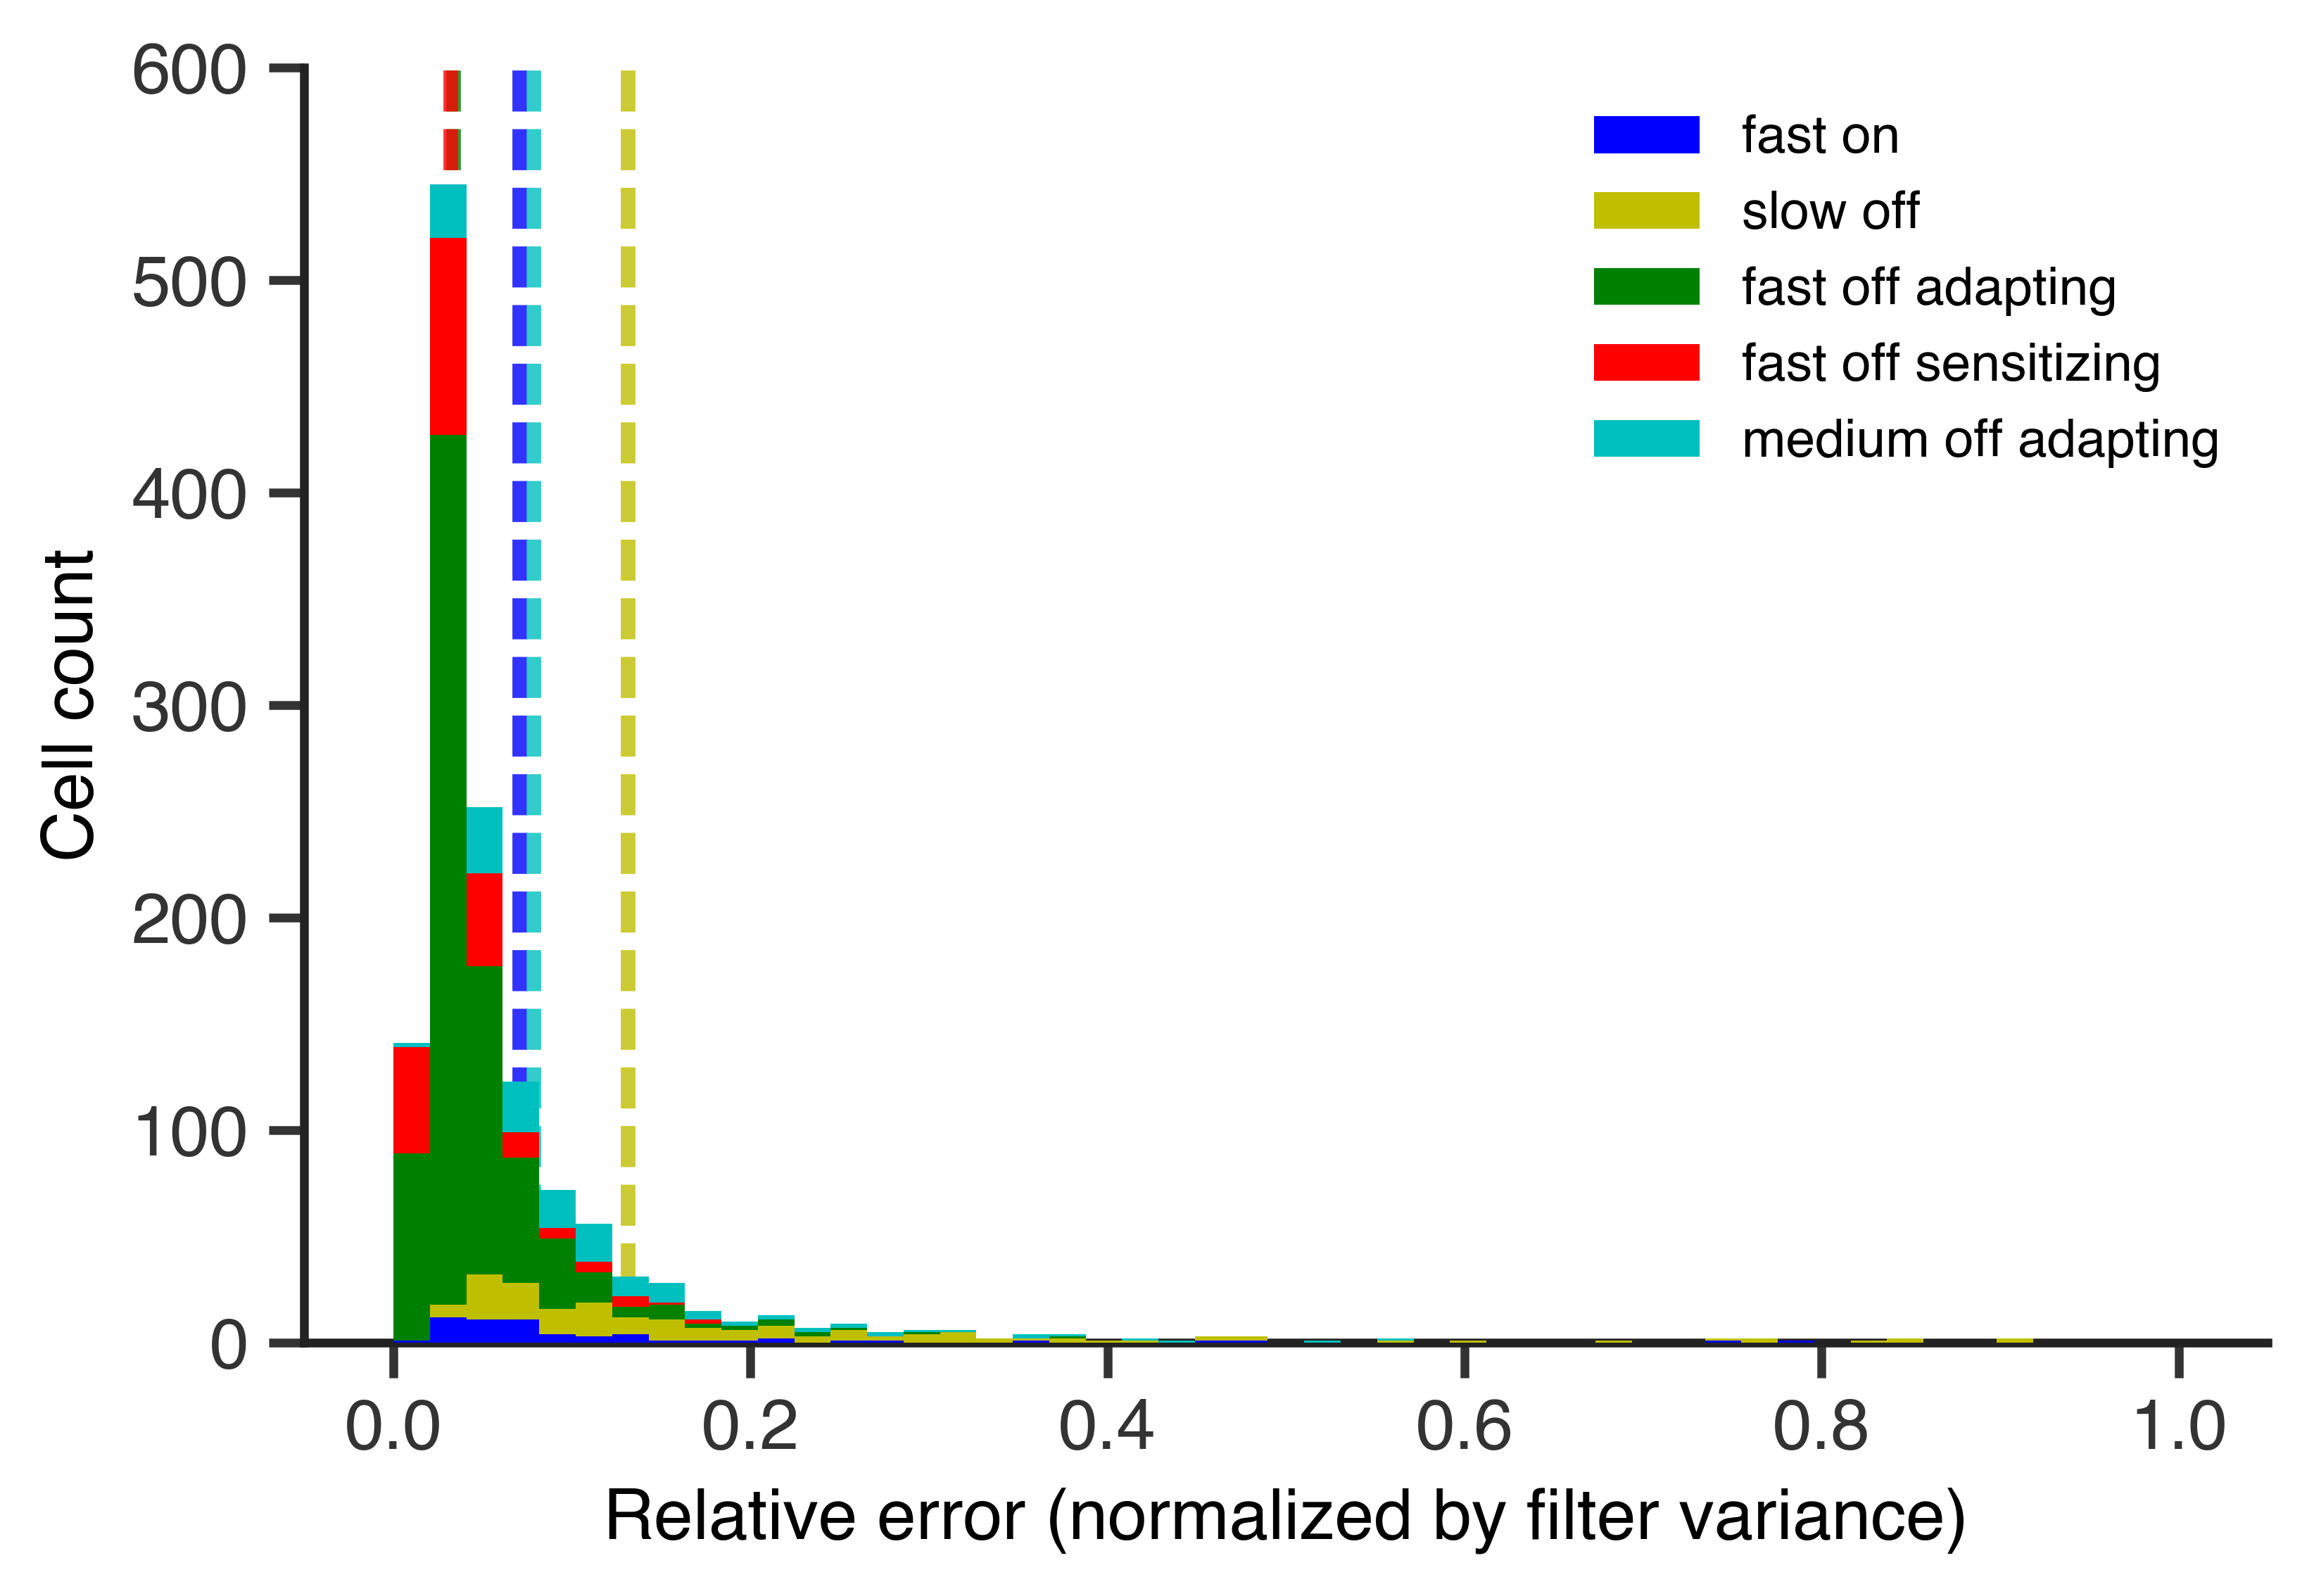

In [40]:
bins = np.linspace(0,1,50)
bin_width = np.mean(np.diff(bins))
prev_count = np.zeros_like(bins[:-1])

ax = plt.gca()

for i,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
        ax.vlines(np.median(rel_error), 0, 600, color=colorscheme[celltype], linestyle='--', alpha=0.8, zorder=i)

    
plt.xlabel('Relative error (normalized by filter variance)')
plt.ylabel('Cell count')
# ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylim(0,600)

for j,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
        count, bins = np.histogram(rel_error, bins=bins)

#         plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
#                 label=' '.join(celltype.split('_')), edgecolor='k', bottom=prev_count, zorder=j+10)

        plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
                label=' '.join(celltype.split('_')), bottom=prev_count, zorder=j+10)

#         plt.bar(bins[:-1]+bin_width/2, count, width=bin_width, color=colorscheme[celltype], 
#                 label=' '.join(celltype.split('_')), alpha=0.9, zorder=j+10)
        prev_count += count


plt.legend(loc='upper right', frameon=False, fontsize=9)
# #plt.savefig('2017-3-29 Percent variance explained by model with median.png')

In [41]:
rel_errors = []
for j,celltype in enumerate(mean_squared_errors.keys()):
    if 'ganglion' != celltype:
        rel_errors.extend(np.array(mean_squared_errors[celltype])/np.array(variances[celltype]))

In [42]:
print(len(rel_errors))
100.*(1. - np.mean(rel_errors))

1354


92.864028499013614

In [43]:
sem(100.*(1. - np.array(rel_errors)))

0.26709443889817819

Correlate the quality of fit with the horz/amacrine fit and the center/surround fit

/home/lane/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lane/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


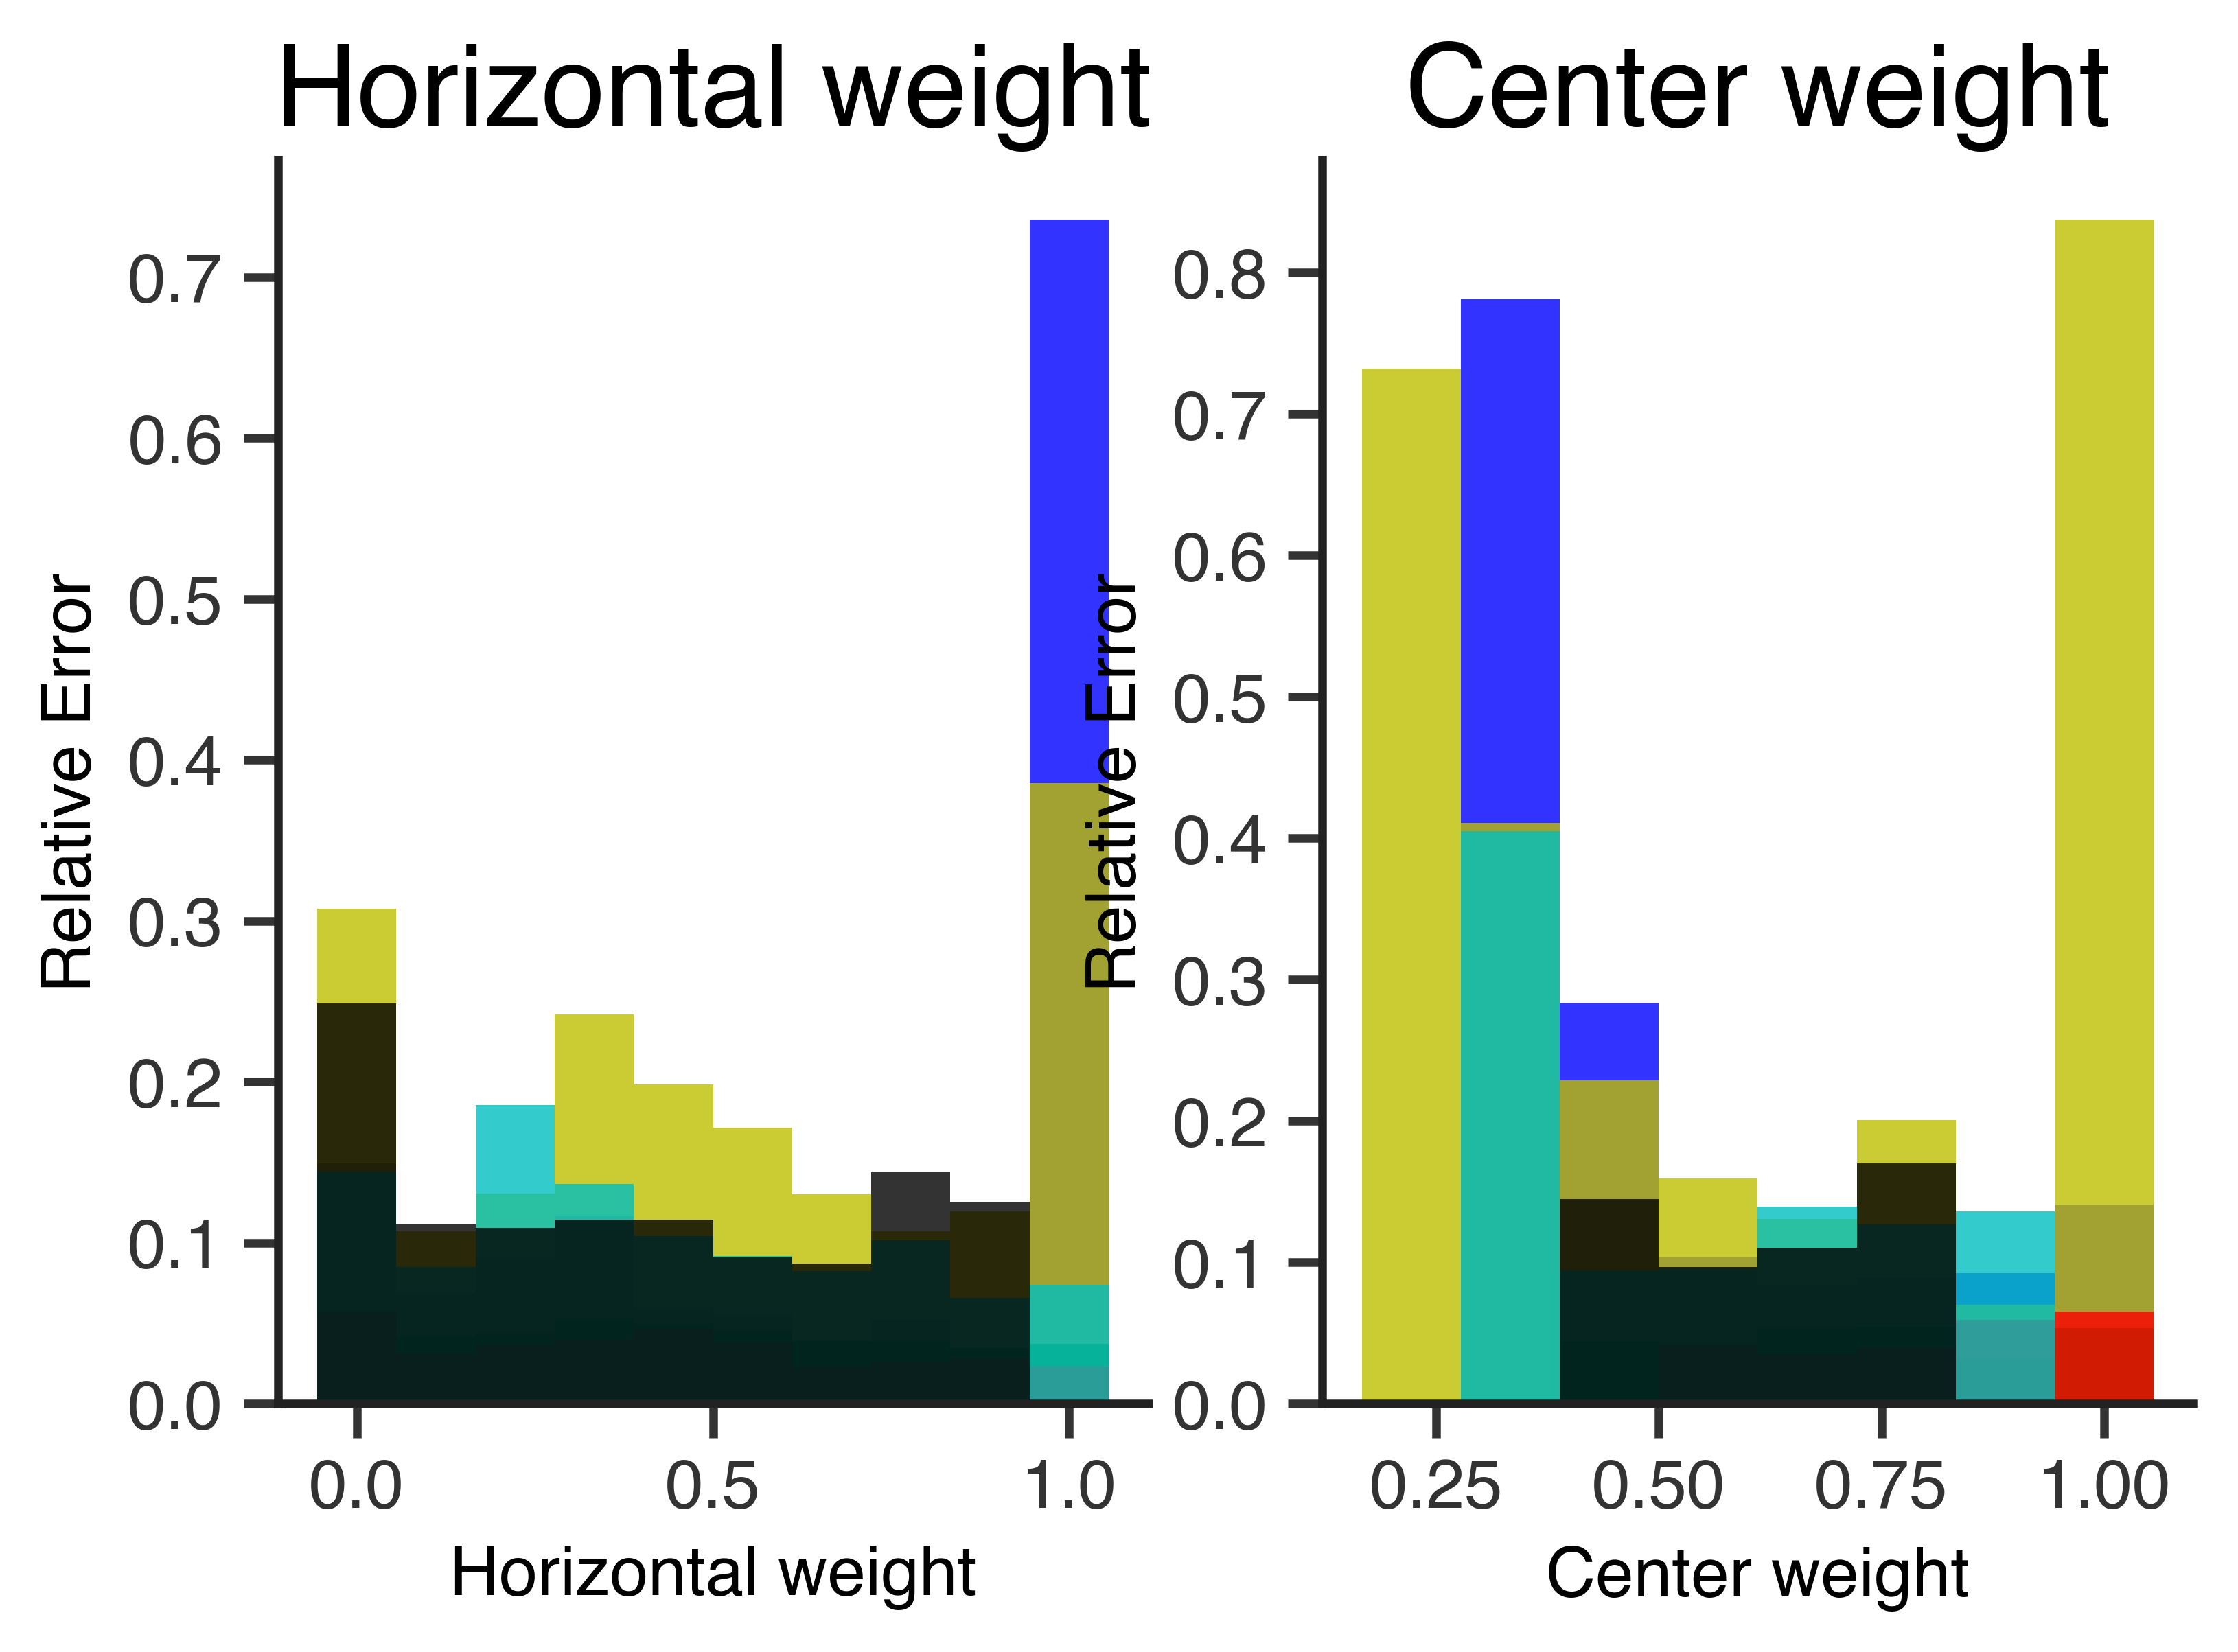

In [44]:
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
relative_errors = collections.defaultdict(list)

hw_bins = np.linspace(0,1,10)
cw_bins = np.linspace(0,1,10)

for celltype in mean_squared_errors.keys():
    rel_error = np.array(mean_squared_errors[celltype])/np.array(variances[celltype])
    relative_errors[celltype] = rel_error
    
    hw_binned_rel_error = [[err for ide,err in enumerate(rel_error) if np.argmin((fits[celltype][ide,0] - hw_bins)**2) == idb] for idb in range(len(hw_bins))]
    cw_binned_rel_error = [[err for ide,err in enumerate(rel_error) if np.argmin((fits[celltype][ide,1] - cw_bins)**2) == idb] for idb in range(len(cw_bins))]
    avg_hw_rel_error = [np.mean(r) for r in hw_binned_rel_error]
    avg_cw_rel_error = [np.mean(r) for r in cw_binned_rel_error]
    
    # Horizontal weight
    ax1.bar(hw_bins, avg_hw_rel_error, width=np.mean(np.diff(hw_bins)), color=colorscheme[celltype],
               label=' '.join(celltype.split('_')), alpha=0.8)
    ax1.set_ylabel('Relative Error')
    ax1.set_xlabel('Horizontal weight')
    ax1.set_title('Horizontal weight')
    
    ax2.bar(cw_bins, avg_cw_rel_error, width=np.mean(np.diff(cw_bins)), color=colorscheme[celltype],
               label=' '.join(celltype.split('_')), alpha=0.8)
    ax2.set_ylabel('Relative Error')
    ax2.set_xlabel('Center weight')
    ax2.set_title('Center weight')

#ax = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
                  
# plt.ylim(0,200)
# #plt.savefig('Percent variance explained by model with median.png')

In [45]:
error_threshold = 0.25

In [46]:
total_number_remaining = 0
total_number_before = 0
for celltype in fits.keys():
    good_fits = float(fits[celltype][relative_errors[celltype] < error_threshold].shape[0])
    all_fits = float(fits[celltype].shape[0])
    print('%f%% of %s' %(100.*good_fits/all_fits, celltype))
    
    total_number_remaining += good_fits
    total_number_before += all_fits

87.931034% of fast_on
75.000000% of slow_off
99.611399% of fast_off_adapting
100.000000% of fast_off_sensitizing
91.823899% of medium_off_adapting
96.428571% of ganglion


In [47]:
1.0*total_number_remaining/total_number_before

0.9558610709117221

#### Mapping ideal fit to our parameter space

In [48]:
global_celltype = 'fast_off_adapting'
iterations = 50

rf = -np.fft.fftshift(np.fft.irfft(ideal_filter))
rf = np.append(rf, rf[-1])

center = gaussian(x=space, sigma=median_center_widths[global_celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

def model_error_to_ganglion_cells(weights):
    hw, cw = weights
    modeled_rf = rf_model(hw, cw)
    normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
    return sum(abs(normed_rf - rf))

best_fit_err = np.inf
for itr in range(iterations):
    this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
    if this_popt.fun < best_fit_err:
        best_fit_err = this_popt.fun
        popt = this_popt

# get mean squared error
modeled_rf = rf_model(*popt.x)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
mse = np.mean((normed_rf - rf)**2)

# truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
x = np.where(abs(popt.x) > 1, 1, abs(popt.x))
ideal_fit = x

Pick examples

In [49]:
fits[celltype][10]

array([ 0.71376139,  0.59842333])

In [50]:
center_weights[np.argmax(np.max(info_maps[celltype], axis=0))]

0.53691275167785235

In [51]:
nexamples = 10
example_rfs = collections.defaultdict(list)
example_ids = collections.defaultdict(list)
example_cws = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
        
        rf_ids = np.arange(len(receptive_fields[celltype]))
        schedule = np.random.permutation(rf_ids)
                
        for i in schedule:
            rf = receptive_fields[celltype][i]
#         for i,rf in enumerate(receptive_fields[celltype]):
            x = fits[celltype][i]
                        
            # collect examples
            if len(example_rfs[celltype]) <= nexamples:
                # check if the fit is close to the optimimum center weight
                if abs(x[1] - center_weights[np.argmax(np.max(info_maps[celltype], axis=0))]) < 0.015:
                    example_rfs[celltype].append(rf)
                    example_ids[celltype].append(i)
                    example_cws[celltype].append(x[1])

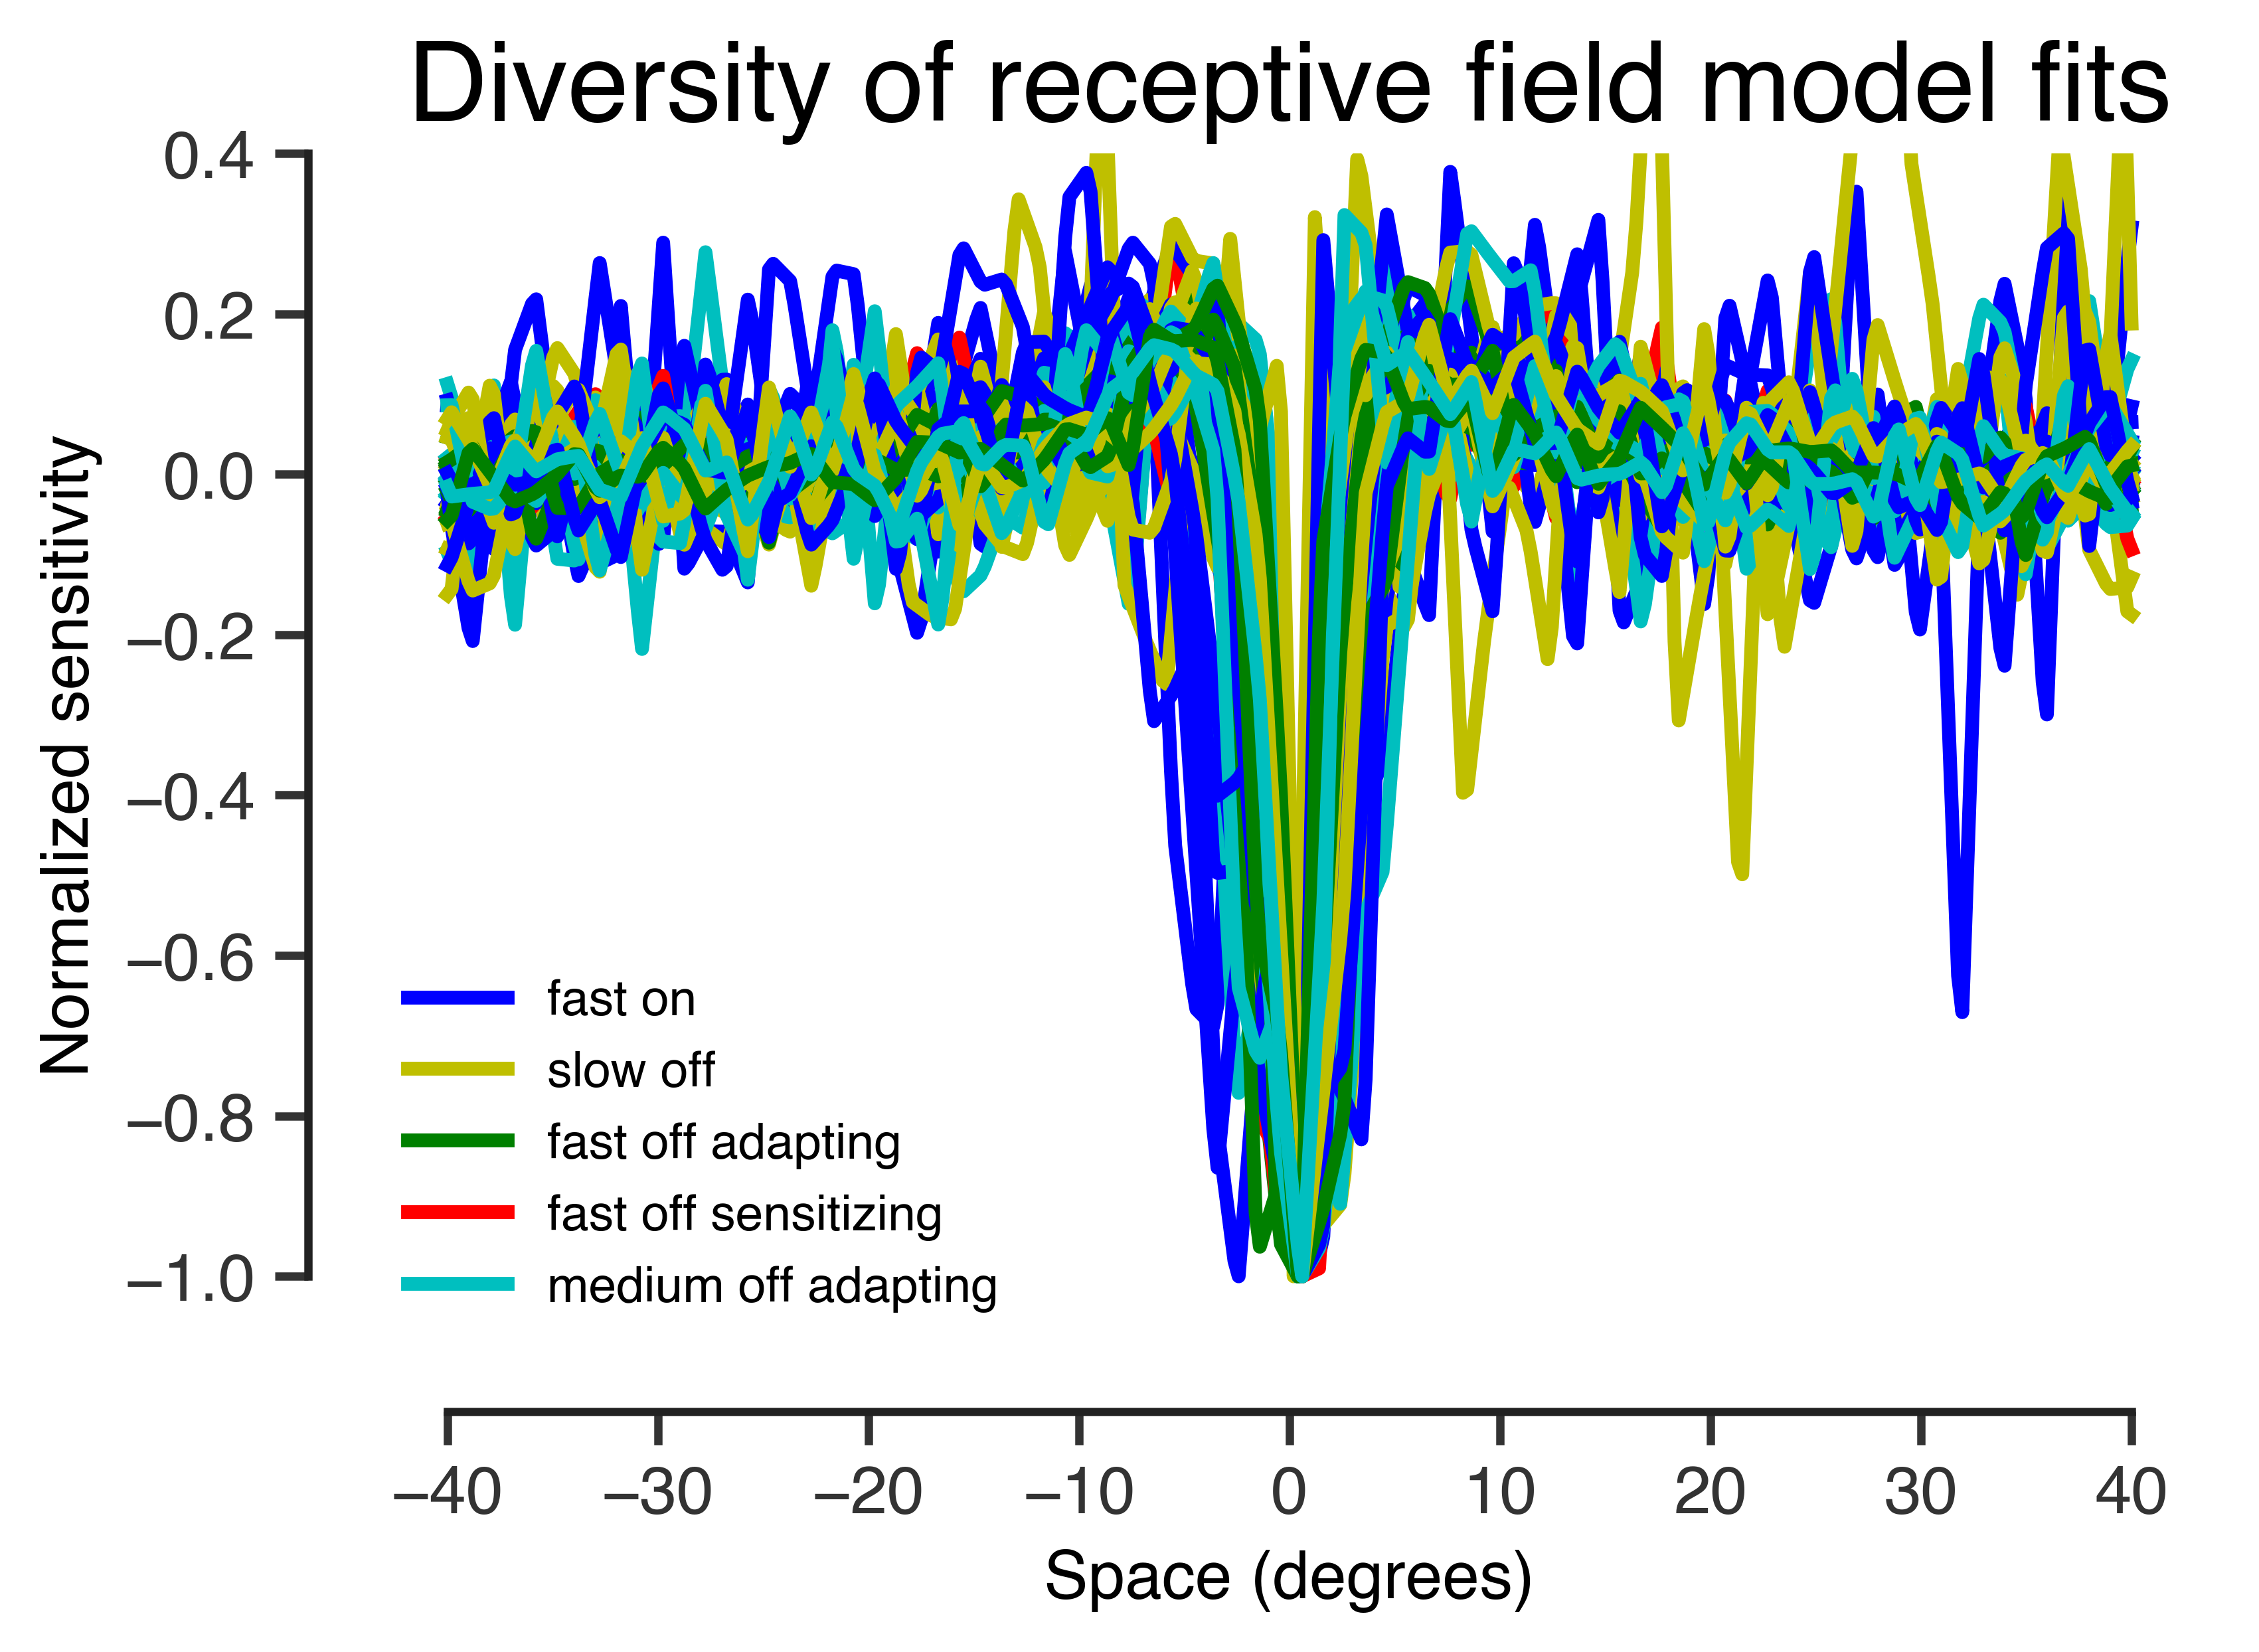

In [52]:
nexamples_for_this_plot = 10
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_rfs.keys():
        if len(example_rfs[celltype]) > ide and celltype != 'ganglion':
            ex = example_rfs[celltype][ide]
            if ide == 0:
                plt.plot(space, ex/np.max(abs(ex)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')))
            else:
                plt.plot(space, ex/np.max(abs(ex)), color=colorscheme[celltype])
            
plt.ylim(-1.1, 0.4)
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized sensitivity')
plt.title('Diversity of receptive field model fits')
plt.legend(loc='lower left', frameon=False, fontsize=9)
adjust_spines(plt.gca())
# #plt.savefig('diversity of receptive fields in space peak with constrained noise rerun 3-27.png')

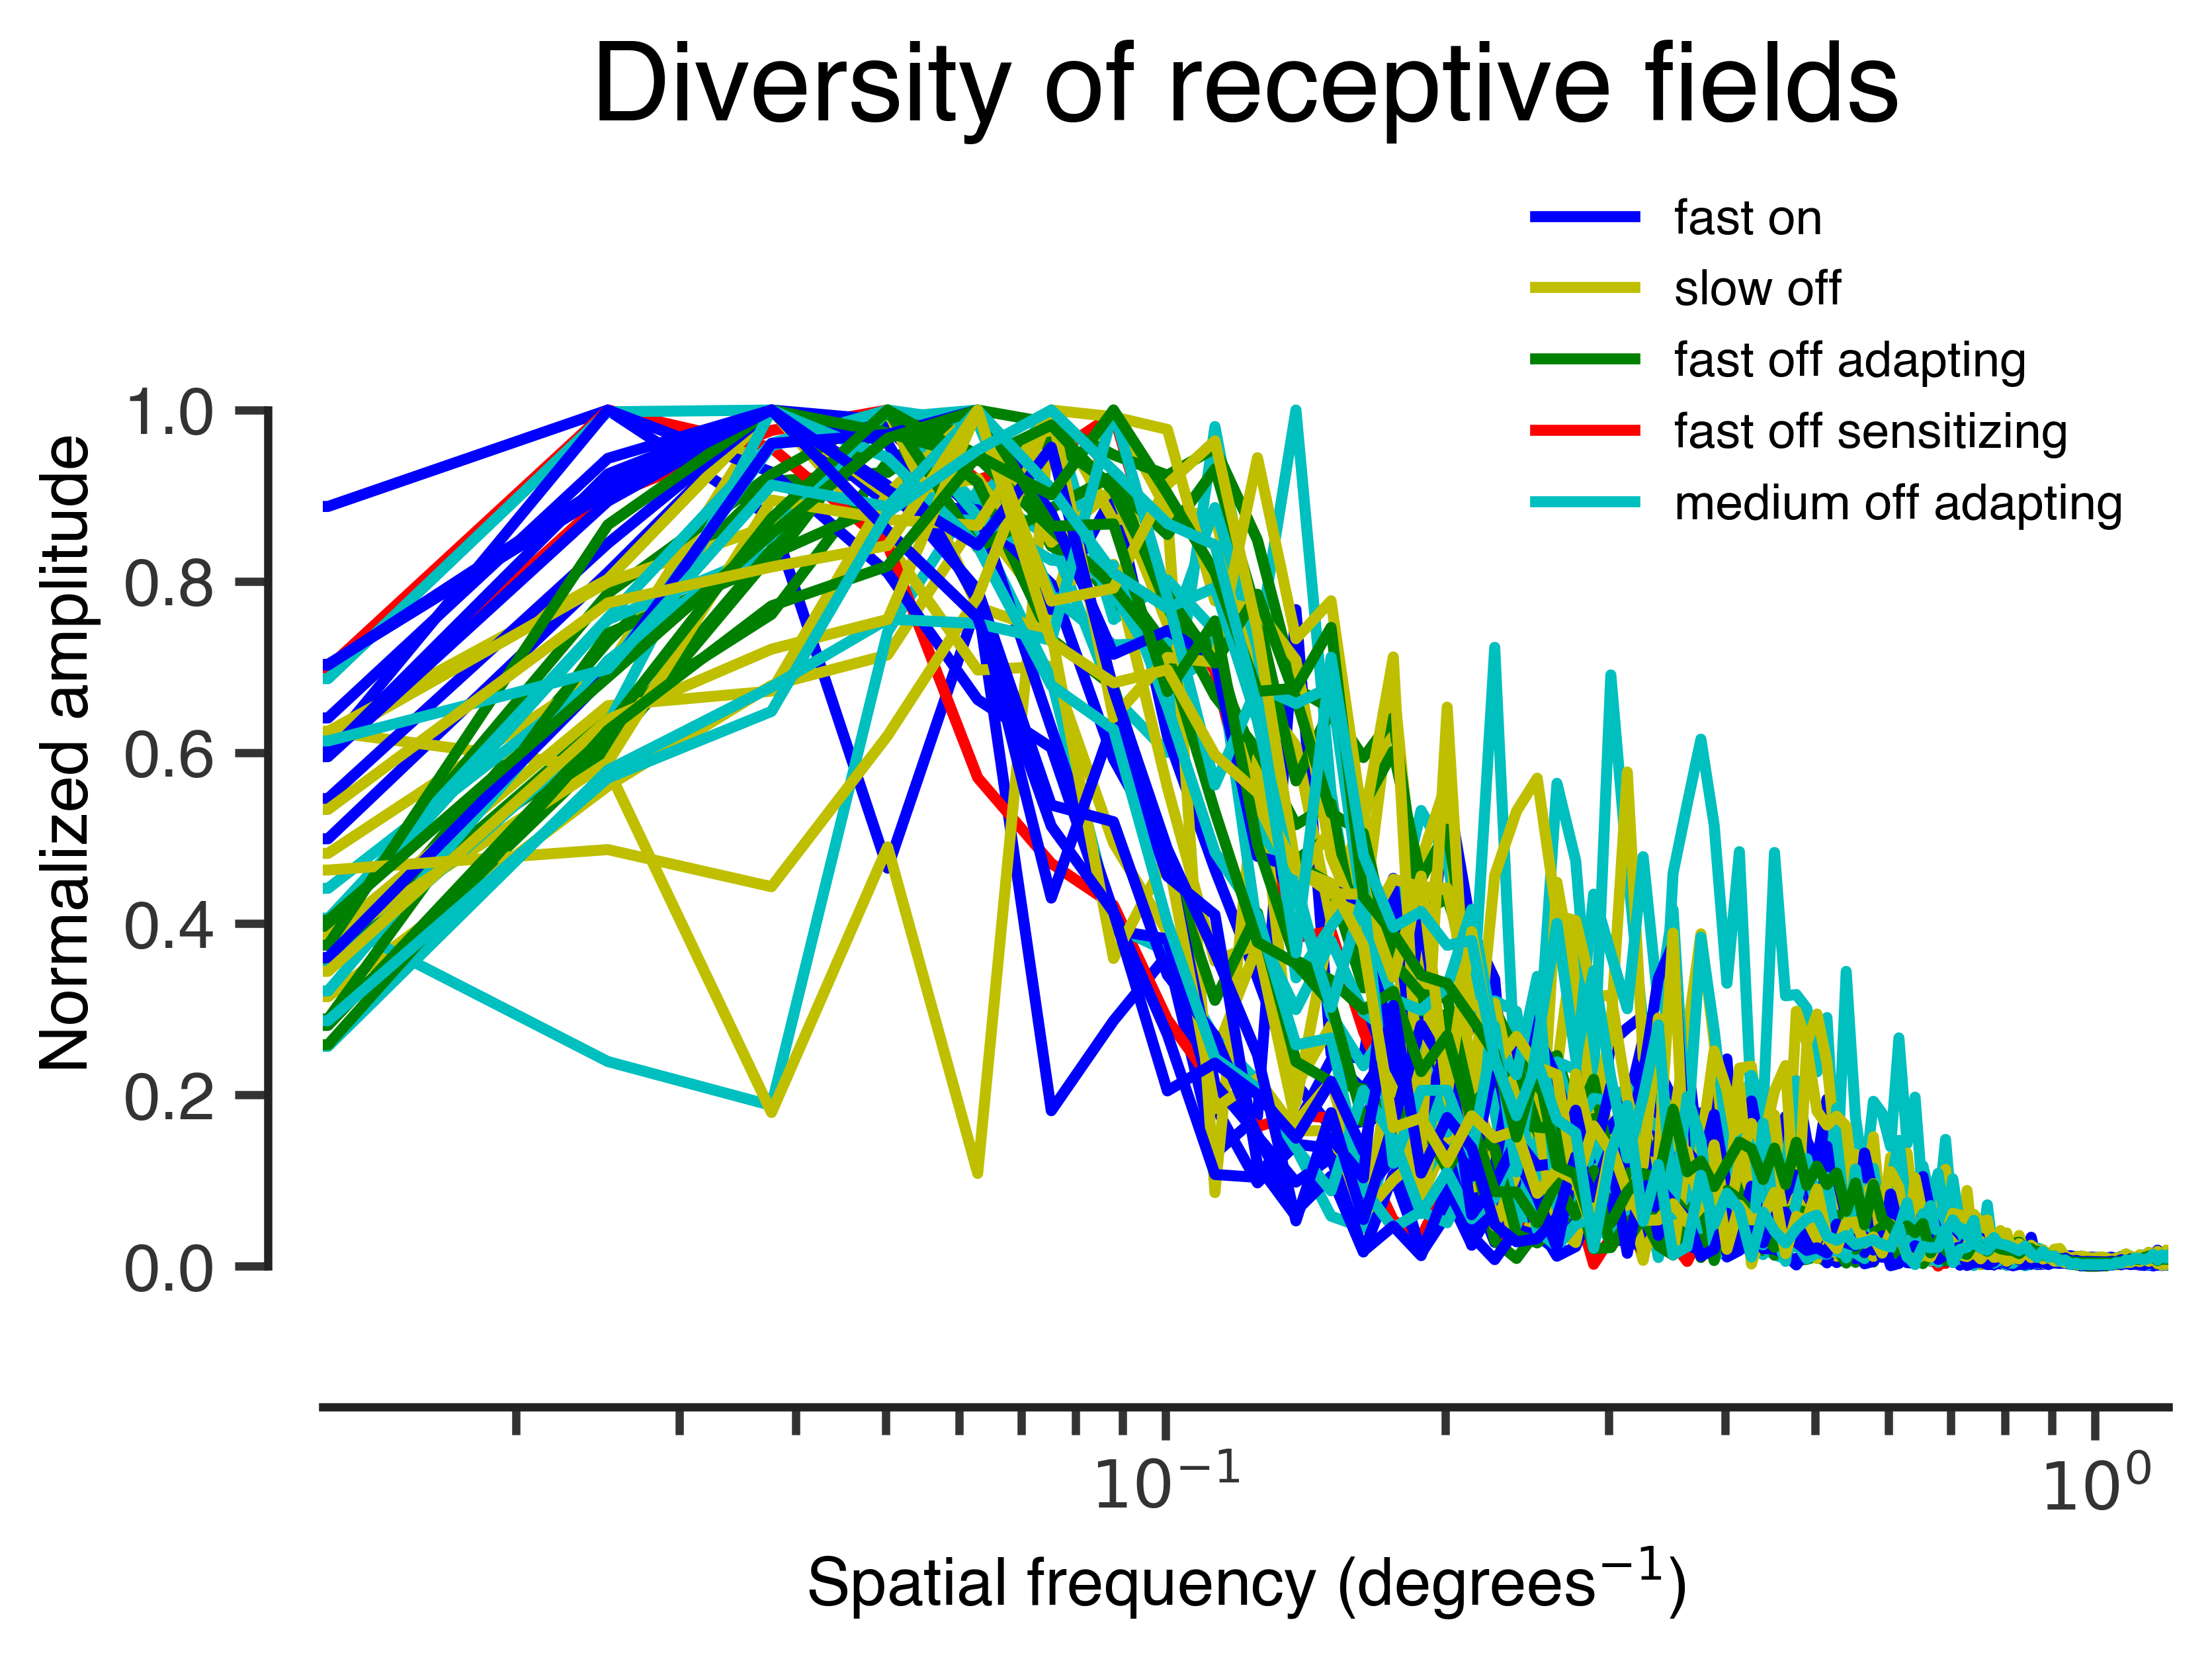

In [53]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_rfs.keys():
        if len(example_rfs[celltype]) > ide and celltype != 'ganglion':
            ex = example_rfs[celltype][ide]
            ex_fft = abs(np.fft.rfft(ex))
            if ide == 0:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')), linewidth=2)
            else:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)),
                         color=colorscheme[celltype], linewidth=2)
            
plt.ylim(-0.1, 1.3)
plt.xlim(0.0124, 1.2)
plt.xscale('log')
plt.xlabel('Spatial frequency (degrees$^{-1}$)')
plt.ylabel('Normalized amplitude')
plt.title('Diversity of receptive fields')
plt.legend(loc='upper right', frameon=False, fontsize=9)
adjust_spines(plt.gca())
# #plt.savefig('diversity of receptive fields in freq logscale peak with constrained noise rerun 1-21.png')

In [54]:
example_cws[celltype]

[0.52214650334364243,
 0.54619753832559348,
 0.53248795751349731,
 0.52604368027024284,
 0.54010850305439961]

In [55]:
fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,1]

array([ 0.5221465 ,  0.54619754,  0.53248796,  0.52604368,  0.5401085 ])

PC1 has explained variance 89.87% percent for all cells
PC1 has explained variance 99.97% percent for fast_on
PC1 has explained variance 99.62% percent for slow_off
PC1 has explained variance 99.74% percent for fast_off_adapting
PC1 has explained variance 99.93% percent for fast_off_sensitizing
PC1 has explained variance 99.65% percent for medium_off_adapting
PC1 has explained variance 99.49% percent for ganglion
Angle difference in radians is 0.0510
Angle difference in degrees is 2.9193


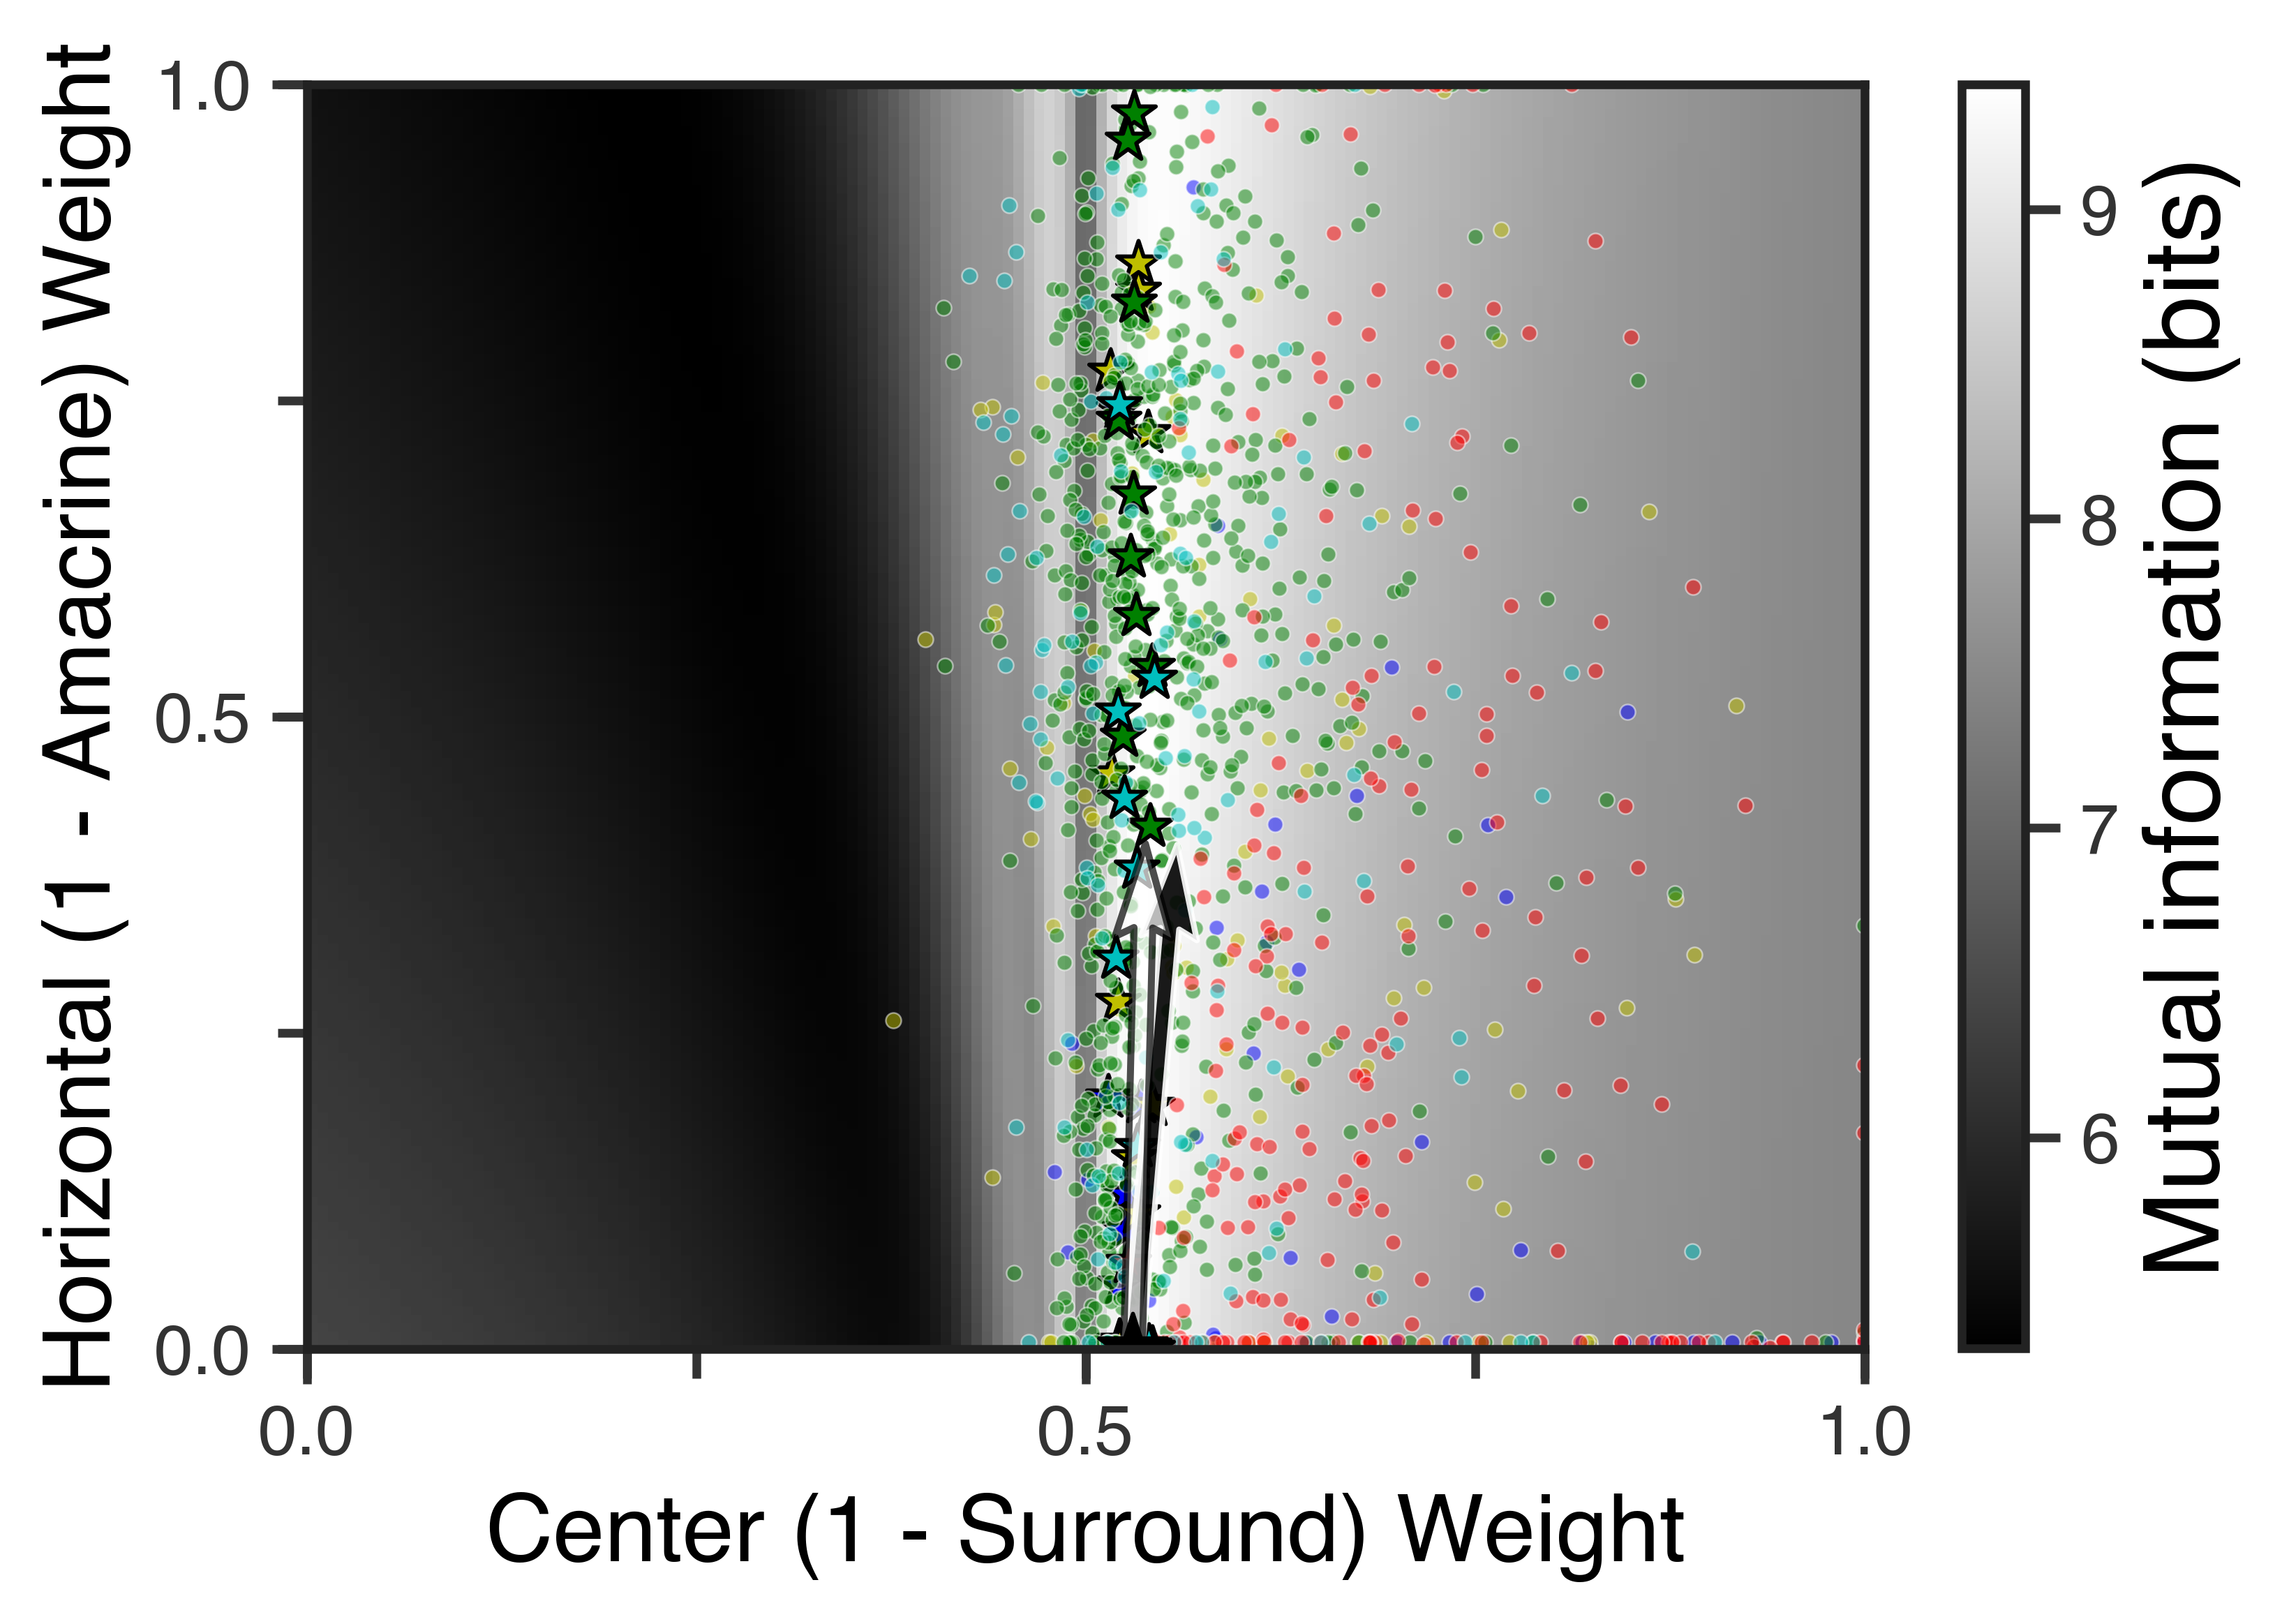

In [56]:
global_celltype = 'medium_off_adapting' #'fast_off_adapting'
point_size = 7 #10
min_info = np.min(info_maps[global_celltype])
max_info = np.max(info_maps[global_celltype])
empirical_ideal_indices = np.unravel_index(np.argmax(info_maps[global_celltype]), info_maps[global_celltype].shape)
empirical_ideal = [horz_weights[empirical_ideal_indices[0]], center_weights[empirical_ideal_indices[1]]]

########## for quivers #########
all_fits = []
# variance_directions = {}
for celltype in fits.keys():
    all_fits.extend(fits[celltype][relative_errors[celltype] < error_threshold])
#     pca = PCA(n_components=2)
#     pca.fit(fits[celltype][relative_errors[celltype] < error_threshold])

#     # flipping the dimensions because fits was saved as horz_weight, center_weight
#     variance_directions[celltype] = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
#     print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))

# average_variance_direction = np.mean(np.stack([variance_directions[k] for k in variance_directions.keys()]), axis=0)
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
# celltype = global_celltype
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.97*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])
    
average_least_info_direction = np.mean([least_info_directions[k] for k in least_info_directions.keys()], axis=0)

angle_diff = np.arctan(average_least_info_direction[1]/average_least_info_direction[0]) - np.arctan(average_variance_direction[1]/average_variance_direction[0])
print('Angle difference in radians is %0.4f' %angle_diff)
angle_diff_degs = (360./(2*np.pi))*angle_diff
print('Angle difference in degrees is %0.4f' %angle_diff_degs)
############ end quivers ###########

plt.imshow(info_maps[global_celltype], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
cbar.set_ticks([6,7,8,9])
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])[relative_errors[celltype] < error_threshold]
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=point_size, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
    plt.scatter(fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,1],
               fits[celltype][example_ids[celltype]][:nexamples_for_this_plot,0],
               c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)


# plt.quiver(ideal_fit[1], ideal_fit[0], average_variance_direction[0], average_variance_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
#           alpha=0.9)
# plt.quiver(ideal_fit[1], ideal_fit[0], average_least_info_direction[0], average_least_info_direction[1],
#            angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
#           alpha=0.7, width=.012, linewidth=1.2)
# plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)

plt.quiver(empirical_ideal[1], empirical_ideal[0], average_variance_direction[0], average_variance_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='k', edgecolor='w', width=0.012, linewidth=1,
          alpha=0.9)
plt.quiver(empirical_ideal[1], empirical_ideal[0], average_least_info_direction[0], average_least_info_direction[1],
           angles='xy', scale_units='xy', scale=2.5, color='w', edgecolor='k',
          alpha=0.7, width=.012, linewidth=1.2)
plt.scatter(empirical_ideal[1], empirical_ideal[0], c='k', edgecolor='k', s=150, marker='*', linewidth=0.7)


# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])


# specify ticks
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
# plt.yticks([0, 0.25, 0.5, 0.75, 1])
majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# #plt.savefig('2017 3-27 Fig3D information map')

In [57]:
angle_diff = np.arctan(average_least_info_direction[1]/average_least_info_direction[0]) - np.arctan(average_variance_direction[1]/average_variance_direction[0])
print('Angle difference in radians is %0.4f' %angle_diff)

Angle difference in radians is 0.0510


In [58]:
angle_diff_degs = (360./(2*np.pi))*angle_diff
print('Angle difference in degrees is %0.4f' %angle_diff_degs)

Angle difference in degrees is 2.9193


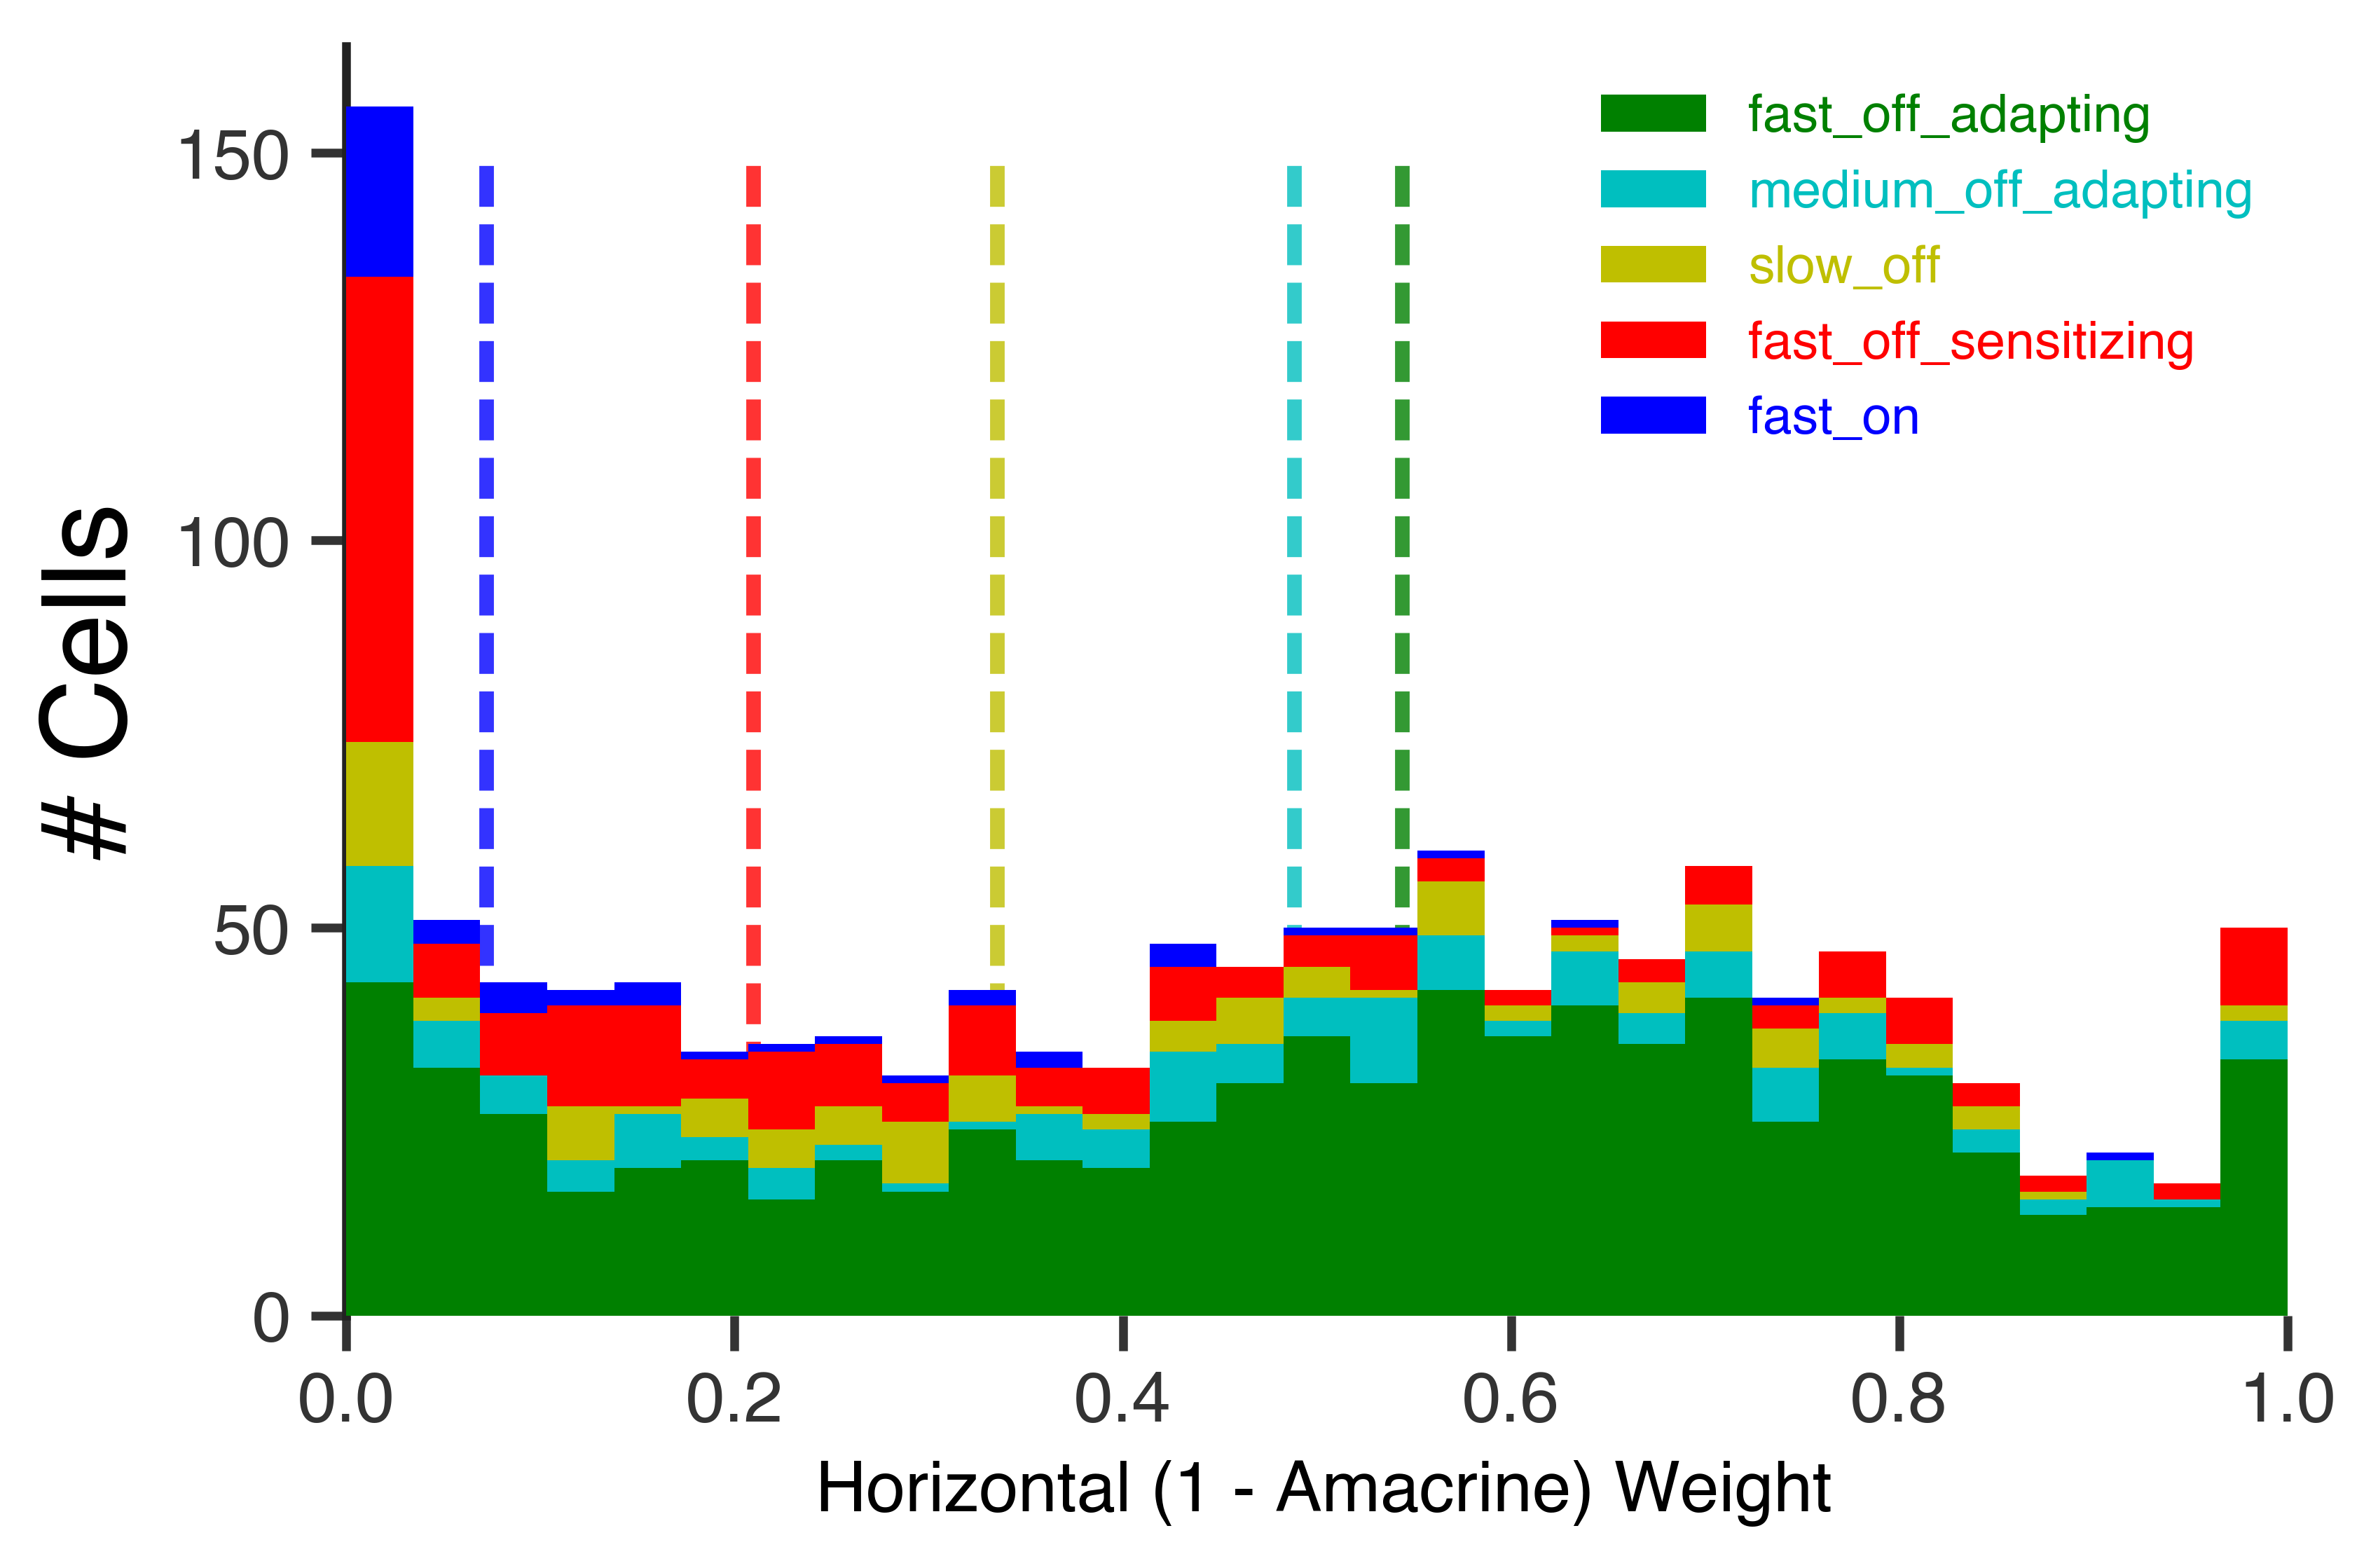

In [60]:
fig = plt.gcf()
ax = plt.gca()

# Histogram
bin_edges = np.linspace(0, 1, 30)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_adapting', 'medium_off_adapting', 'slow_off', 'fast_off_sensitizing', 'fast_on']):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(fits[celltype][:, 0][relative_errors[celltype] < error_threshold],
                                        bins=bin_edges)
#         ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')), zorder=c+20)
        ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5, label=' '.join(celltype.split(' ')), zorder=c+20)
#         ax.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                linewidth=0.5, label=' '.join(celltype.split(' ')), alpha=0.9, zorder=c+20)

        prev_count += this_count
        
        plt.vlines(np.median(fits[celltype][:, 0][relative_errors[celltype] < error_threshold]),
                   0, 150, color=colorscheme[celltype], linestyle='--', alpha=0.8, zorder=c)
        
l = plt.legend(frameon=False, fontsize=9, loc='upper right')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

        

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('# Cells', color='k', fontsize=20)
ax.set_xlabel('Horizontal (1 - Amacrine) Weight')
# ax.set_ylim(0,140)
# ax.set_yticks([0,100,200,300])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_visible(False)

# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')



majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# #plt.savefig('1d y-axis distribution 3-29.png')

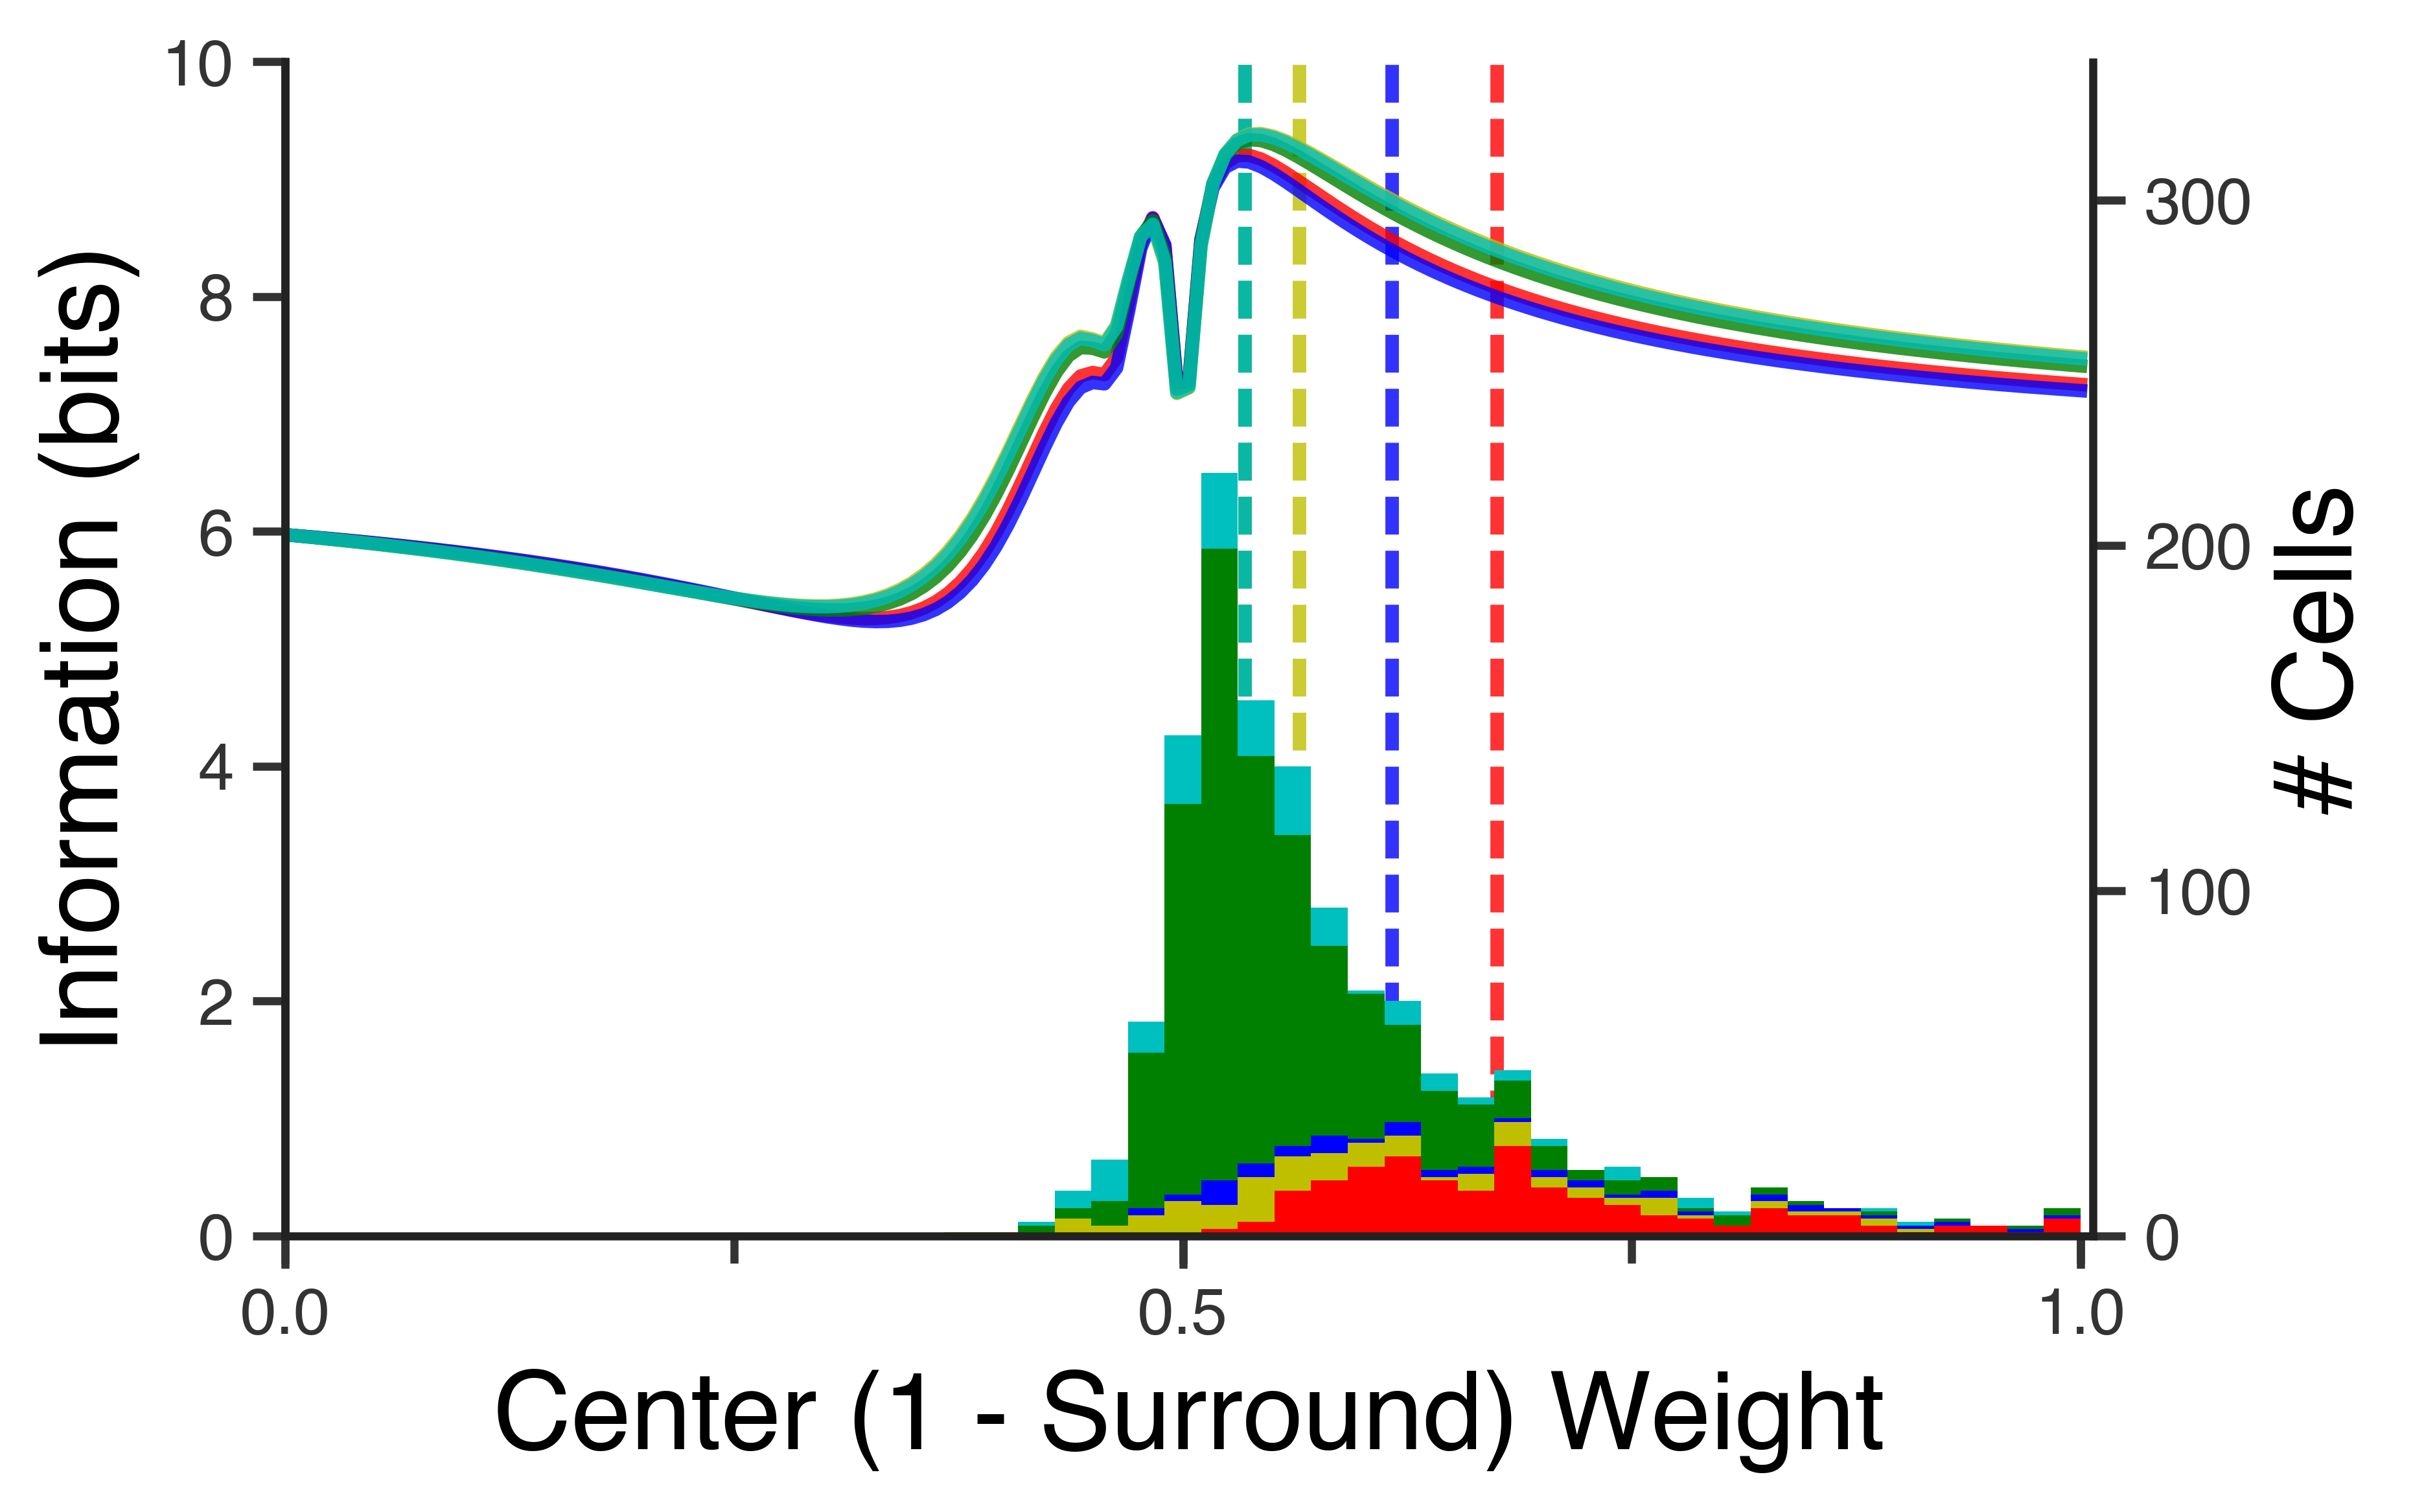

In [62]:
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_sensitizing', 'slow_off', 'fast_on', 'fast_off_adapting',
                             'medium_off_adapting']):
    if celltype != 'ganglion':
        plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[celltype])
        infos_at_horz_slice = []
        center_weight_fits = np.stack(fits[celltype])[:, 1][relative_errors[celltype] < error_threshold]
        for f in fits[celltype]:
            idx = np.argmin(abs(f[0] - horz_weights))
            idy = np.argmin(abs(f[1] - center_weights))
            infos_at_horz_slice.append(info_maps[celltype][idx, idy])

    #     color = np.random.rand(3)
#         plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[celltype], 
#                     label=' '.join(celltype.split('_')), s=30, edgecolor='w', lw=0.5)
        plt.vlines(np.median(center_weight_fits), 0, 11, color=colorscheme[celltype], linestyle='--', alpha=0.8)
    
# l = plt.legend(frameon=False, fontsize=9, loc='upper left')
# for text in l.get_texts():
#     splitlabel = text.properties()['text'].split(' ')
#     text.set_color(colorscheme['_'.join(splitlabel)])

plt.ylabel('Information (bits)', fontsize=20)
# adjust_spines(plt.gca())
plt.ylim(0, 10)
plt.xlim(0,1.1)
ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.spines['bottom'].set_visible(False)
plt.xticks([])
ax1.set_xlabel('Center (1 - Surround) Weight', fontsize=20)

majorLocator = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator = MultipleLocator(0.25)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])

ax2 = ax1.twinx()
# for c, celltype in enumerate(fits.keys()):
for c, celltype in enumerate(['fast_off_sensitizing', 'slow_off', 'fast_on', 'fast_off_adapting',
                             'medium_off_adapting']):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits[celltype])[:, 1][relative_errors[celltype] < error_threshold],
                                        bins=bin_edges)
#         ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                bottom=prev_count, linewidth=0.5, edgecolor='k')
        ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5)
#         ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
#                linewidth=0.5, alpha=0.85)

        prev_count += this_count

plt.xlim(0,1.007)
# plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_ylabel('# Cells', color='k', fontsize=20)
ax2.set_ylim(0,340)
ax2.set_yticks([0,100,200,300])

# ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
# #plt.savefig('1d info slice with histogram with constrained noise rerun 3-29.png')

# Fig 3A

(0, 0.3)

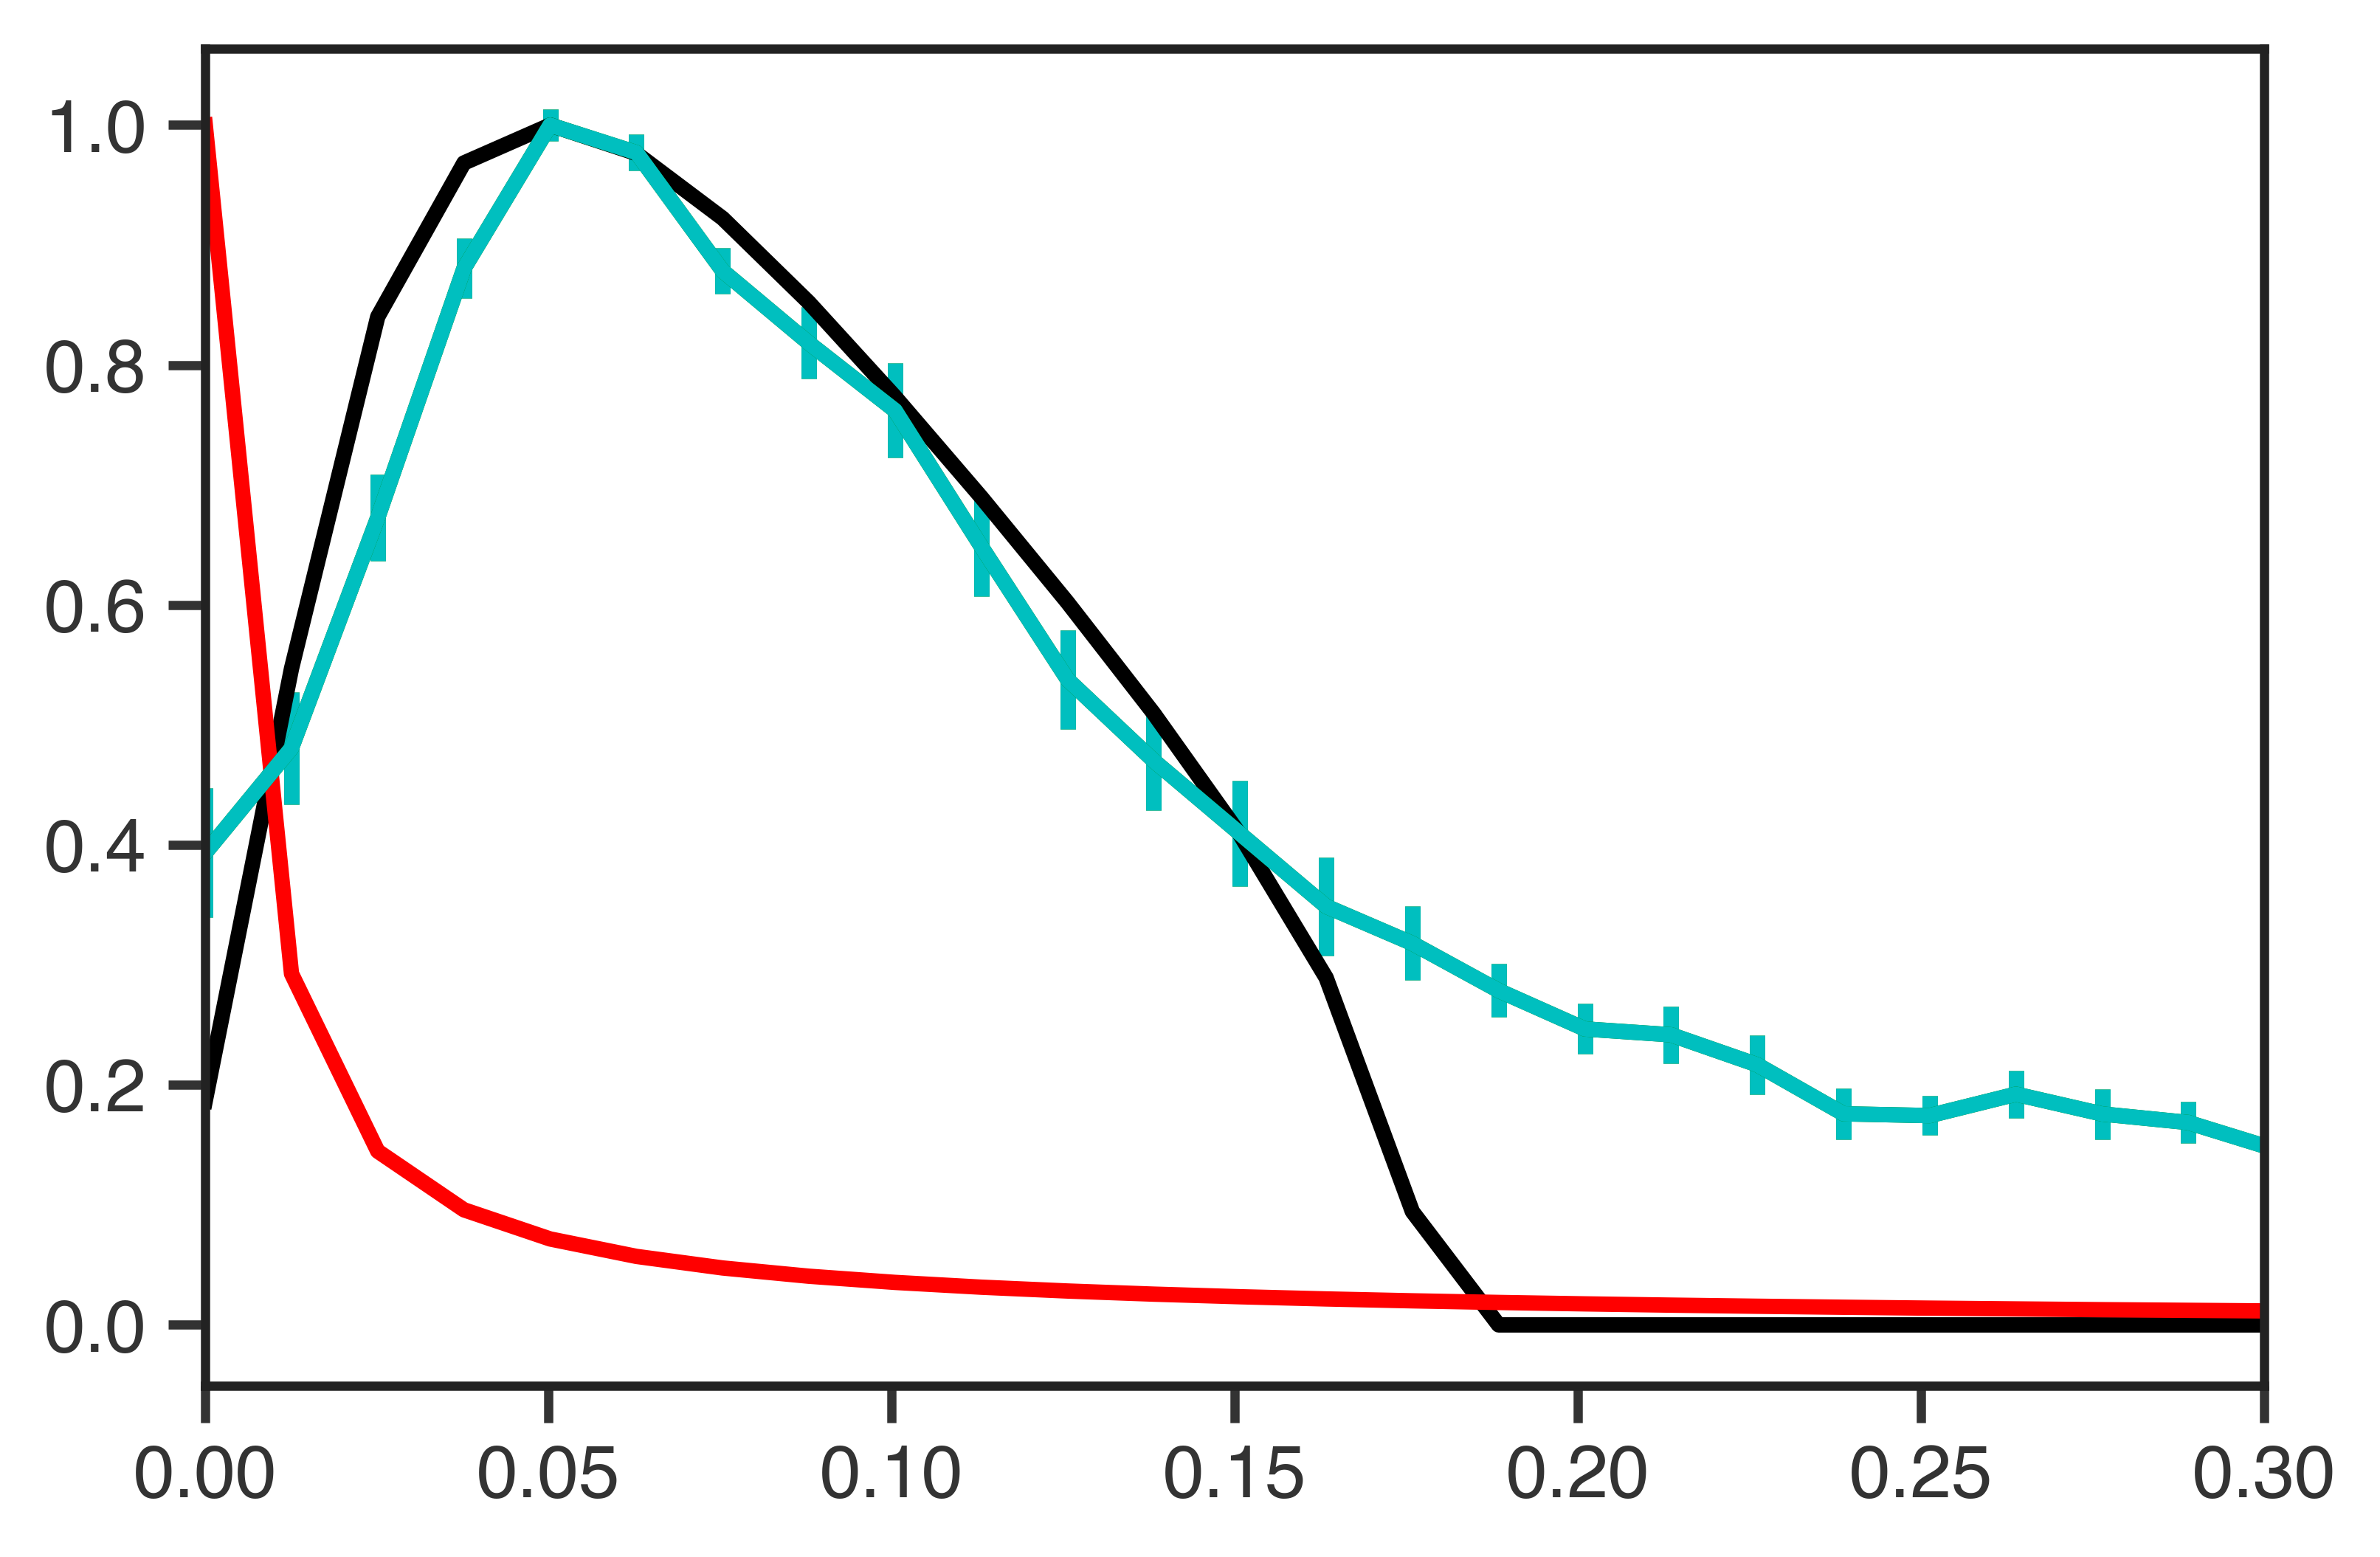

In [112]:
ffts = []
for rf in receptive_fields['ganglion']:
    this_fft = abs(np.fft.rfft(rf))
    this_fft /= np.max(this_fft)
    ffts.append(this_fft)

# avg_rf = np.mean(receptive_fields['ganglion'], axis=0)
# avg_rf_fft = abs(np.fft.rfft(avg_rf))
# plt.plot(freqs, avg_rf_fft)

sems = sem(np.stack(ffts))
stds = np.std(np.stack(ffts), axis=0)
avg_rf_fft = abs(np.mean(np.stack(ffts), axis=0))
avg_rf_fft2 = np.mean(abs(np.stack(ffts)), axis=0)

plt.errorbar(freqs, avg_rf_fft/np.max(avg_rf_fft), yerr=sems/np.max(avg_rf_fft), color='g')
plt.errorbar(freqs, avg_rf_fft2/np.max(avg_rf_fft2), yerr=sems/np.max(avg_rf_fft2), color='c')
# plt.errorbar(freqs, avg_rf_fft2/np.max(avg_rf_fft2), yerr=stds/np.max(avg_rf_fft2), color='y')
plt.plot(freqs, ideal_filter/np.max(ideal_filter), color='k')
plt.plot(freqs, signal/np.max(signal), 'r')
plt.xlim(0, 0.3)

# Figures 3F & G

## Compute info while varying surround widths

In [121]:
widths = np.linspace(0.01, 17, 100)
init_filt_const = 10.9
resolution = 100
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [122]:
infos_varying_width = collections.defaultdict(list)
celltype = 'fast_off_adapting'
with h5py.File('infos_varying_width.h5', 'r') as f:
    tmp = dict(f)
    width_tuples = list(tmp.keys())
    for k in width_tuples:
        lhs, rhs = k.split(',')
        w1 = float(lhs.split('(')[1])
        w2 = float(rhs.split(')')[0])
        infos_varying_width[(w1, w2)] = np.array(f[k])

In [124]:
max_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        max_info_vs_width[idw1, idw2+idw1] = np.max(infos_varying_width[(w1,w2)])
        max_info_vs_width[idw2+idw1, idw1] = np.max(infos_varying_width[(w1,w2)])

In [125]:
popt_horz, pcov = curve_fit(gaussian, space, horz_pf, p0=[2.5, 0.0, 2.1])
popt_ama, pcov = curve_fit(gaussian, space, ama_pf, p0=[2.5, 0.0, 2.1])

In [163]:
popt_horz

array([ 7.55361739,  0.71971159,  3.66314634])

In [164]:
popt_ama

array([ 3.07582526,  0.0265504 ,  1.30682383])

In [128]:
min_info = None
max_info = None
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        new_min = np.min(infos_varying_width[(w1,w2)])
        new_max = np.max(infos_varying_width[(w1,w2)])
        if (not min_info) or (min_info > new_min):
            min_info = new_min
        if (not max_info) or (max_info < new_max):
            max_info = new_max

In [127]:
max_info

9.4720612730635256

In [123]:

colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

## Data part

In [129]:
data_dir = os.path.expanduser('~/data/kastner/')
h_file = 'horizontals.h5'
a_file = 'amacrines.h5'

In [130]:
interneuron_rfs = collections.defaultdict(list)
with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['horizontal'].append(sign_of_pc * g_pca)

with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['amacrine'].append(sign_of_pc * g_pca)

9it [00:00, 241.36it/s]
27it [00:00, 120.81it/s]


In [131]:
space_constant = {
    'horizontal': 121./microns_per_degree, #118./microns_per_degree,
    'amacrine': 102./microns_per_degree #78./microns_per_degree
    }
conv_mode = 'full'
# spatial delta in mm * 1000) / microns_per_degree # microns * degrees/microns = degrees
interneuron_spacing = (2.2/100.) # in mm

interneuron_rfs_1d = collections.defaultdict(list)
for interneuron_type in interneuron_rfs.keys():
    for rf in interneuron_rfs[interneuron_type]:
        this_space = get_space(rf, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        proj_range = [np.exp(-abs(t)/space_constant[interneuron_type]) for t in np.linspace(np.min(this_space),
                                                                                    np.max(this_space),len(this_space))]
        proj_field = np.convolve(proj_range, rf, mode=conv_mode)
        proj_field *= np.mean(rf) / np.mean(proj_field)
        
        proj_space = get_space(proj_field, np.diff(this_space[:2]), microns_per_degree, in_degrees=False)
        component_interp = interp1d(proj_space, proj_field, kind='slinear', bounds_error=False, fill_value=[0])
        interneuron_rfs_1d[interneuron_type].append(component_interp(space))

In [132]:

colorscheme = {
    'horizontal': 'g',
    'amacrine': 'b'
}

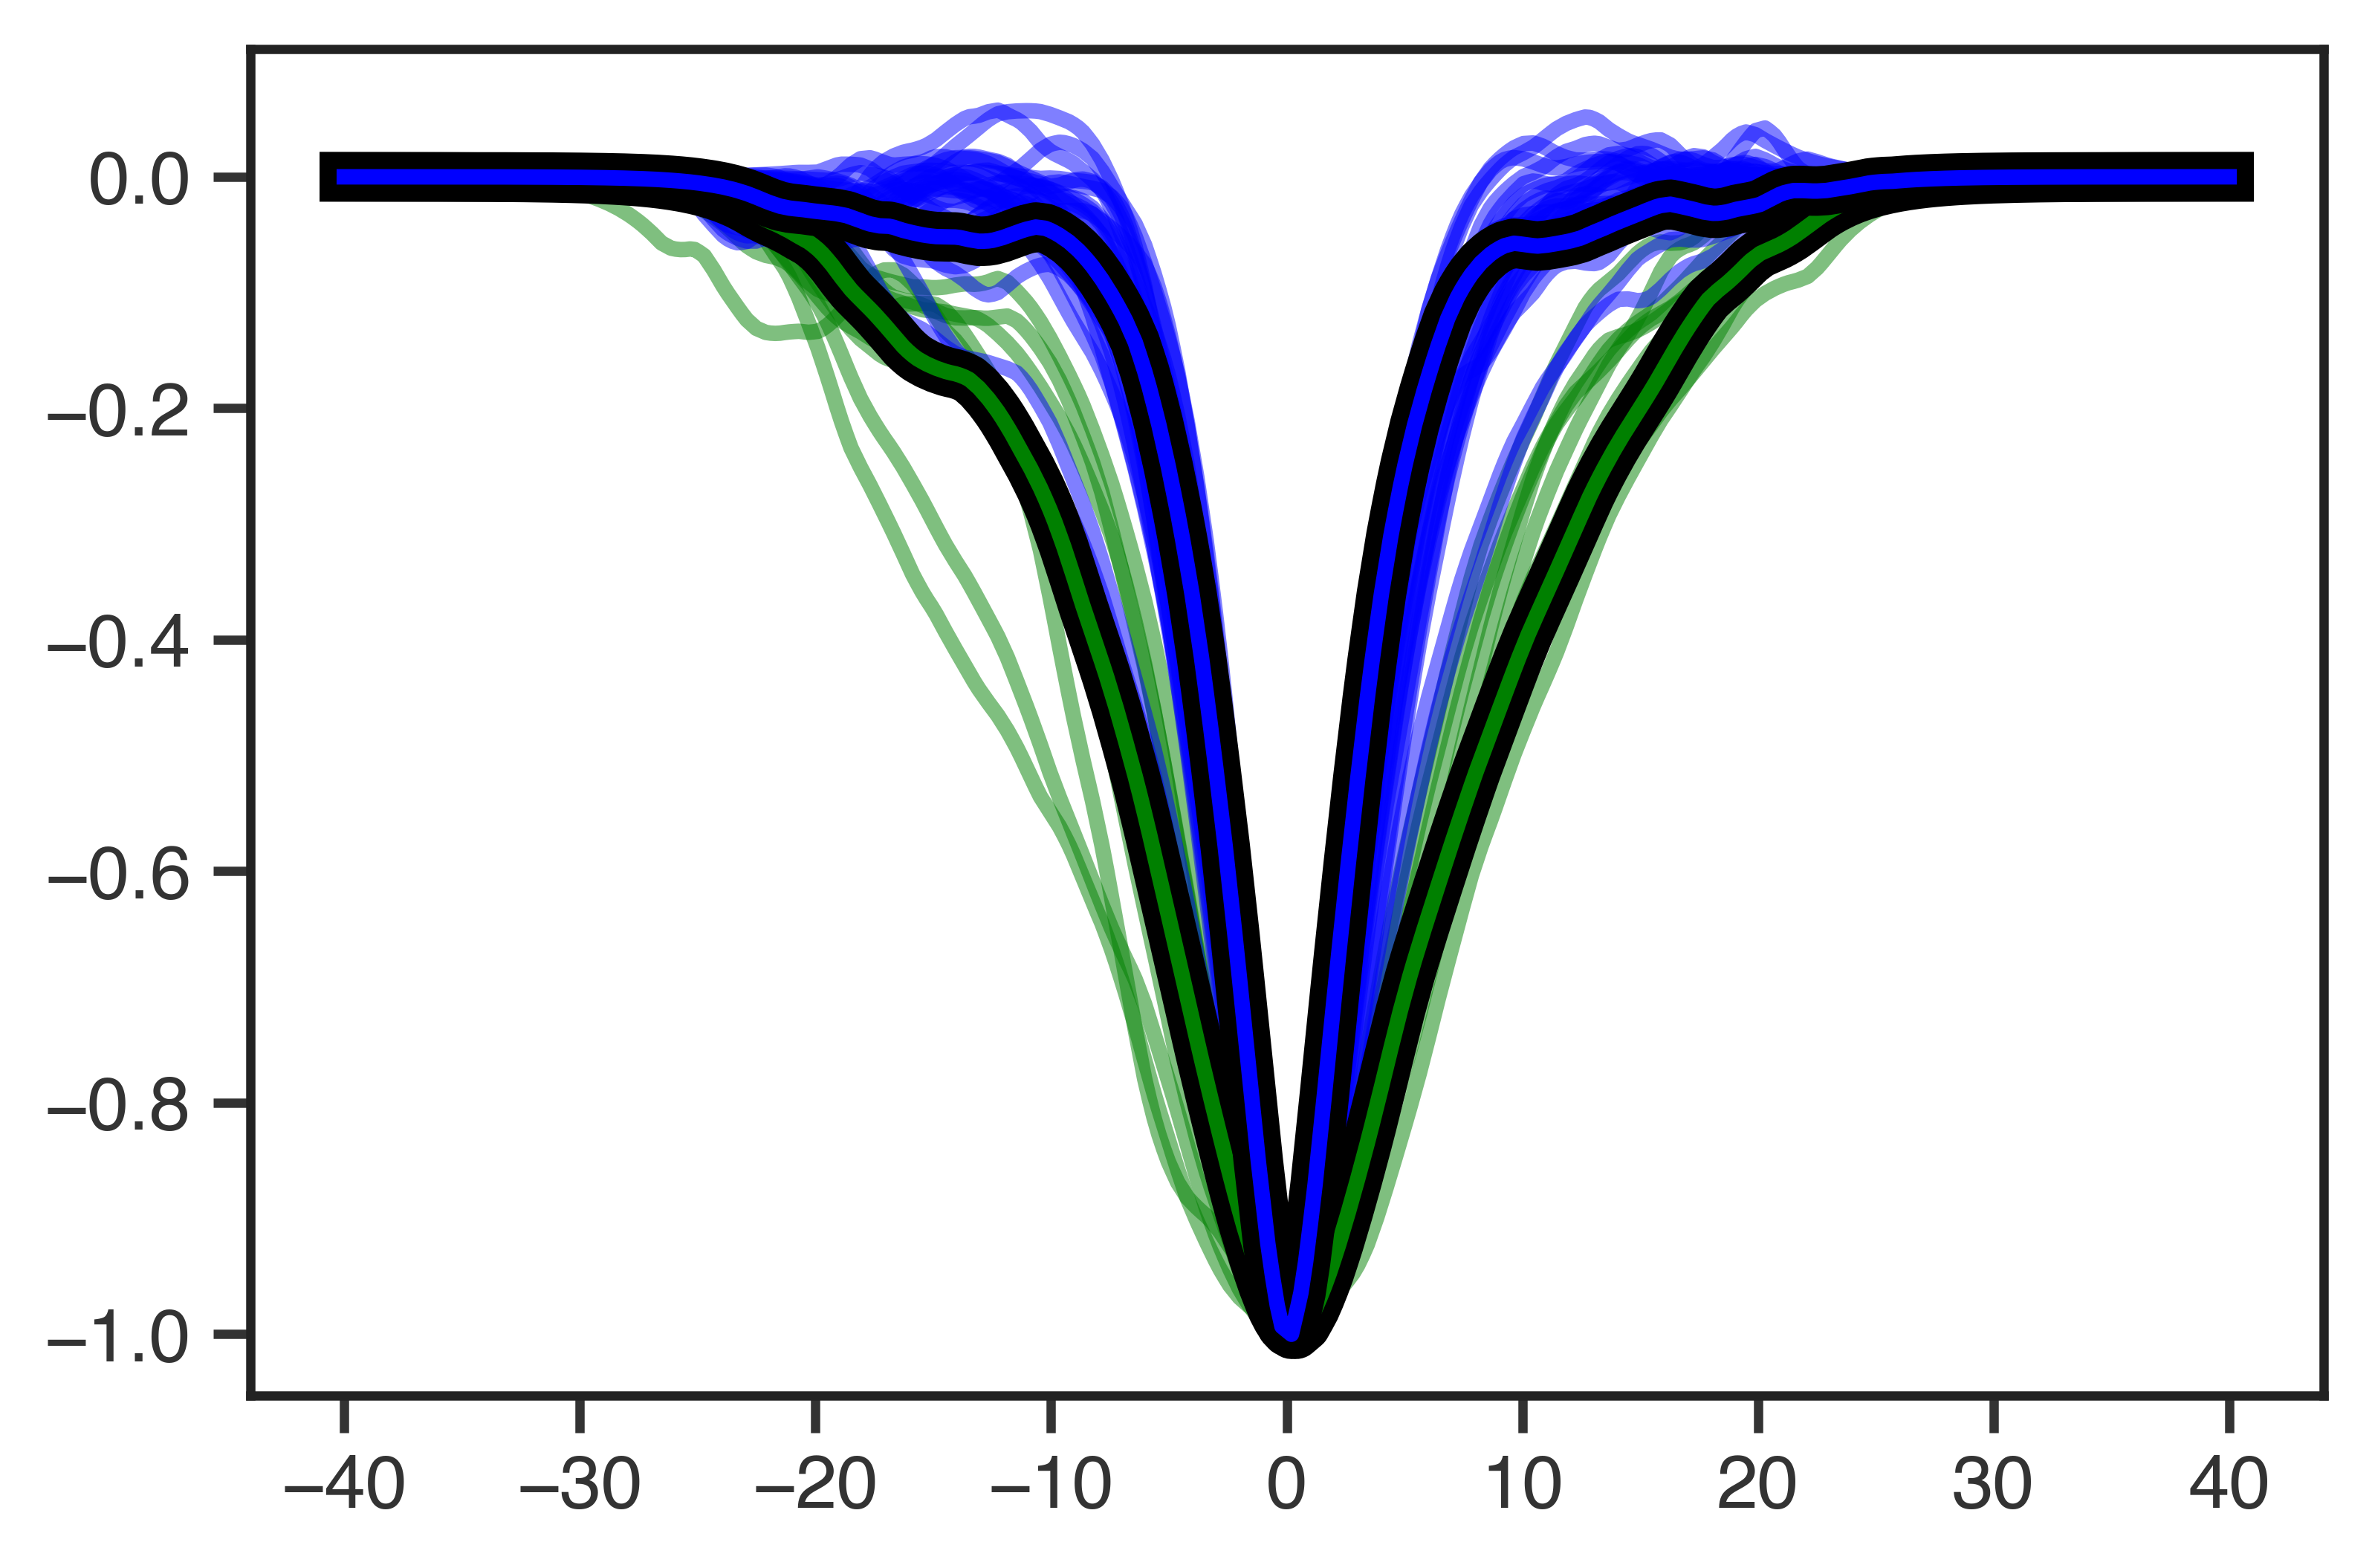

In [133]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        plt.plot(space, component/np.max(abs(component)), color=colorscheme[interneuron_type], alpha=0.5)

plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'k', linewidth=8)
plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'g')
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'k', linewidth=8)
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'b')

In [134]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        popt, pcov = curve_fit(gaussian, space, -component, p0=[2.5, 0.0, 2.1])
        interneuron_fits[interneuron_type].append(abs(popt[0]))

In [135]:
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths)
interneuron_pairs = np.outer(count_horz, count_ama)

In [136]:
def angle(rf1, rf2):
    # an arccos(x > 1) returns nan. But we get some values x that are 1.0000000002 due to numerical imprecision
    opp_hyp = np.min([1, np.inner(rf1, rf2)/(np.sqrt(np.sum(rf1**2)) * np.sqrt(np.sum(rf2**2)))])
    a = np.arccos(opp_hyp)
    return np.min([a, abs(a - 2*np.pi)])
#     return np.arccos(np.inner(rf1, rf2)/(np.sqrt(np.sum(rf1**2)) * np.sqrt(np.sum(rf2**2))))

In [137]:
max_angles_fft = np.zeros((len(widths), len(widths)))
max_angles_rf = np.zeros((len(widths), len(widths)))
info_difference = np.zeros((len(widths), len(widths)))
all_angles = []
all_dots = []
all_arccos = []
all_info_losses = []

center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for idw1,w1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2,w2 in enumerate(widths[idw1:]):
#         print((w1,w2))
        surround2 = gaussian(x=space, sigma=w2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        rf = rf_model(hw, cw)
        rf_filt = abs(np.fft.rfft(rf))
        this_info = infos_varying_width[(w1,w2)][which_fft[0], which_fft[1]]
        max_angle_fft = -1
        max_angle_rf = -1
        for idh,new_hw in enumerate(horz_weights):
#             if w1 != w2:
# #                 if new_hw != hw:
#                 import pdb
#                 pdb.set_trace()
            
            new_rf = rf_model(new_hw, cw)
            new_filt = abs(np.fft.rfft(new_rf))
            new_rf_angle = angle(rf, new_rf)
            new_fft_angle = angle(rf_filt, new_filt)
            
            all_angles.append(new_rf_angle)
            all_dots.append(np.inner(rf, new_rf)/(np.sqrt(np.sum(rf**2)) * np.sqrt(np.sum(new_rf**2))))
            all_arccos.append(np.arccos(np.min([1,all_dots[-1]])))
            all_info_losses.append(infos_varying_width[(w1,w2)][idh, which_fft[1]]/max_info)
            
            if new_rf_angle > max_angle_rf:
                max_angle_rf = new_rf_angle
            if new_fft_angle > max_angle_fft:
                max_angle_fft = new_fft_angle
                new_info = infos_varying_width[(w1,w2)][idh, which_fft[1]]
#                 associated_info_diff = new_info/this_info
                associated_info_diff = new_info/max_info
                
        max_angles_rf[idw1, idw2+idw1] = max_angle_rf
        max_angles_rf[idw2+idw1, idw1] = max_angle_rf
        max_angles_fft[idw1, idw2+idw1] = max_angle_fft
        max_angles_fft[idw2+idw1, idw1] = max_angle_fft
        info_difference[idw1, idw2+idw1] = associated_info_diff
        info_difference[idw2+idw1, idw1] = associated_info_diff

In [141]:
best_indices = []
thresholds = np.linspace(0.01, 0.5, 20)
for thresh in thresholds:
    angles = max_angles_fft.ravel()
    infos = info_difference.ravel()
    local_max_info = 0
    for i,a in enumerate(angles):
        if a > thresh:
            if infos[i] > local_max_info:
                local_max_info = infos[i]
                best_index = np.unravel_index(i, info_difference.shape)
    best_indices.append(best_index)

In [142]:
max_angles_fft_data = []
max_angles_rf_data = []
max_info_difference_data = []

for h_width in interneuron_fits['horizontal']:
    surround2 = gaussian(x=space, sigma=h_width, mu=0.)
    surround2 /= np.sum(surround2)
    
    # choose the closest width in our lookup table
    w2_idx = np.argmin(np.abs(h_width - widths))
    w2 = widths[w2_idx]
    
    for a_width in interneuron_fits['amacrine']:
        surround1 = gaussian(x=space, sigma=a_width, mu=0.)
        surround1 /= np.sum(surround1)
        
        # choose the closest width in our lookup table
        w1_idx = np.argmin(np.abs(a_width - widths))
        w1 = widths[w1_idx]

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        if w1 > w2:
            print('Triggered! %f, %f' %(h_width, a_width))
            tmp = w1
            w1 = w2
            w2 = tmp
            
            def rf_model(horz_weight, center_weight):
                return center_weight*center + (1-center_weight)*(horz_weight*surround1 + (1-horz_weight)*surround2)
            
        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        rf = rf_model(hw, cw)
        rf_filt = abs(np.fft.rfft(rf))
        this_info = infos_varying_width[(w1,w2)][which_fft[0], which_fft[1]]
        max_angle_fft = 0
        max_angle_rf = 0
        for idh,hw in enumerate(horz_weights):
            new_rf = rf_model(hw, cw)
            new_filt = abs(np.fft.rfft(new_rf))
            new_rf_angle = angle(rf, new_rf)
            new_fft_angle = angle(rf_filt, new_filt)
            
            if new_rf_angle > max_angle_rf:
                max_angle_rf = new_rf_angle
            if new_fft_angle > max_angle_fft:
                max_angle_fft = new_fft_angle
                new_info = infos_varying_width[(w1,w2)][idh, which_fft[1]]
                associated_info_diff = new_info/this_info
                
        max_angles_rf_data.append(max_angle_rf)
        max_angles_fft_data.append(max_angle_fft)
        max_info_difference_data.append(associated_info_diff)

Triggered! 5.234103, 5.799910
Triggered! 5.234103, 6.037796


In [143]:
angles_fft_data = []
angles_rf_data = []
info_difference_data = []

for h_width in interneuron_fits['horizontal']:
    surround2 = gaussian(x=space, sigma=h_width, mu=0.)
    surround2 /= np.sum(surround2)
    
    # choose the closest width in our lookup table
    w2_idx = np.argmin(np.abs(h_width - widths))
    w2 = widths[w2_idx]
    
#     surround2 = gaussian(x=space, sigma=w2, mu=0.)
#     surround2 /= np.sum(surround2)
    
    for a_width in interneuron_fits['amacrine']:
        surround1 = gaussian(x=space, sigma=a_width, mu=0.)
        surround1 /= np.sum(surround1)
        
        # choose the closest width in our lookup table
        w1_idx = np.argmin(np.abs(a_width - widths))
        w1 = widths[w1_idx]
        
#         surround1 = gaussian(x=space, sigma=w1, mu=0.)
#         surround1 /= np.sum(surround1)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        if w1 > w2:
            print('Triggered! %f, %f' %(h_width, a_width))
            tmp = w1
            w1 = w2
            w2 = tmp
            
            def rf_model(horz_weight, center_weight):
                return center_weight*center + (1-center_weight)*(horz_weight*surround1 + (1-horz_weight)*surround2)
            
        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

        all_h_rf = rf_model(horz_weights[-1], cw)
        all_a_rf = rf_model(horz_weights[0], cw)
        
        all_h_fft = abs(np.fft.rfft(all_h_rf))
        all_a_fft = abs(np.fft.rfft(all_a_rf))
                
        angles_rf_data.append(angle(all_h_rf, all_a_rf))
        angles_fft_data.append(angle(all_h_fft, all_a_fft))
        info_difference_data.append(mean_info/max_info)

Triggered! 5.234103, 5.799910
Triggered! 5.234103, 6.037796


In [144]:
real_angles_fft = [np.min([a, abs(a - 2*np.pi)]) for a in max_angles_fft.ravel()]

In [146]:
angles_fft_opposite_edges = np.zeros((len(widths), len(widths)))
angles_rf_opposite_edges = np.zeros((len(widths), len(widths)))
info_difference_opposite_edges = np.zeros((len(widths), len(widths)))

center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for idw1,w1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2,w2 in enumerate(widths[idw1:]):
        surround2 = gaussian(x=space, sigma=w2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        this_map = infos_varying_width[(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        
        mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

        all_h_rf = rf_model(horz_weights[-1], cw)
        all_a_rf = rf_model(horz_weights[0], cw)
        
        all_h_fft = abs(np.fft.rfft(all_h_rf))
        all_a_fft = abs(np.fft.rfft(all_a_rf))
        
        angle_rf = angle(all_h_rf, all_a_rf)
        if np.isnan(angle_rf):
            angle_rf = 0
            
        angle_fft = angle(all_h_fft, all_a_fft)
        if np.isnan(angle_fft):
            angle_fft = 0
                
        angles_rf_opposite_edges[idw1, idw2+idw1] = angle_rf
        angles_rf_opposite_edges[idw2+idw1, idw1] = angle_rf
        angles_fft_opposite_edges[idw1, idw2+idw1] = angle_fft
        angles_fft_opposite_edges[idw2+idw1, idw1] = angle_fft
        info_difference_opposite_edges[idw1, idw2+idw1] = mean_info/max_info
        info_difference_opposite_edges[idw2+idw1, idw1] = mean_info/max_info

## Plots

In [147]:
radians_to_deg = 360./(2.*np.pi)
colors = ['b', 'g', 'r']

In [148]:
example_ids = []
example_angles = []
example_info_loss = []
flag = [0,0,0]
for i,(this_angle,info) in enumerate(zip(angles_fft_opposite_edges.ravel(), info_difference_opposite_edges.ravel())):
    angle_deg = radians_to_deg * this_angle
    info_loss = 100*(1. - info)
    if (angle_deg > 10) and (angle_deg < 20) and (info_loss > 12.) and (info_loss < 50.) and (flag[0] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[0] = 1
        
    if (angle_deg > 40) and (angle_deg < 44) and (info_loss > 30.) and (flag[1] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[1] = 1
        
    if (angle_deg > 26) and (angle_deg < 30) and (info_loss < 2.6) and (flag[2] == 0):
        print((angle_deg, info_loss))
        example_ids.append(np.unravel_index(i, angles_fft_opposite_edges.shape))
        example_angles.append(angle_deg)
        example_info_loss.append(info_loss)
        flag[2] = 1

(17.180155022180124, 12.240050283229731)
(41.296894381565515, 31.843836499724819)
(26.031856054849467, 2.1201074476321913)


In [149]:
example_ids

[(2, 3), (5, 13), (17, 80)]

In [150]:
for idw1, idw2 in example_ids:
    print((widths[idw1], widths[idw2]))

(0.35323232323232323, 0.5248484848484849)
(0.86808080808080801, 2.2410101010101009)
(2.9274747474747471, 13.739292929292928)


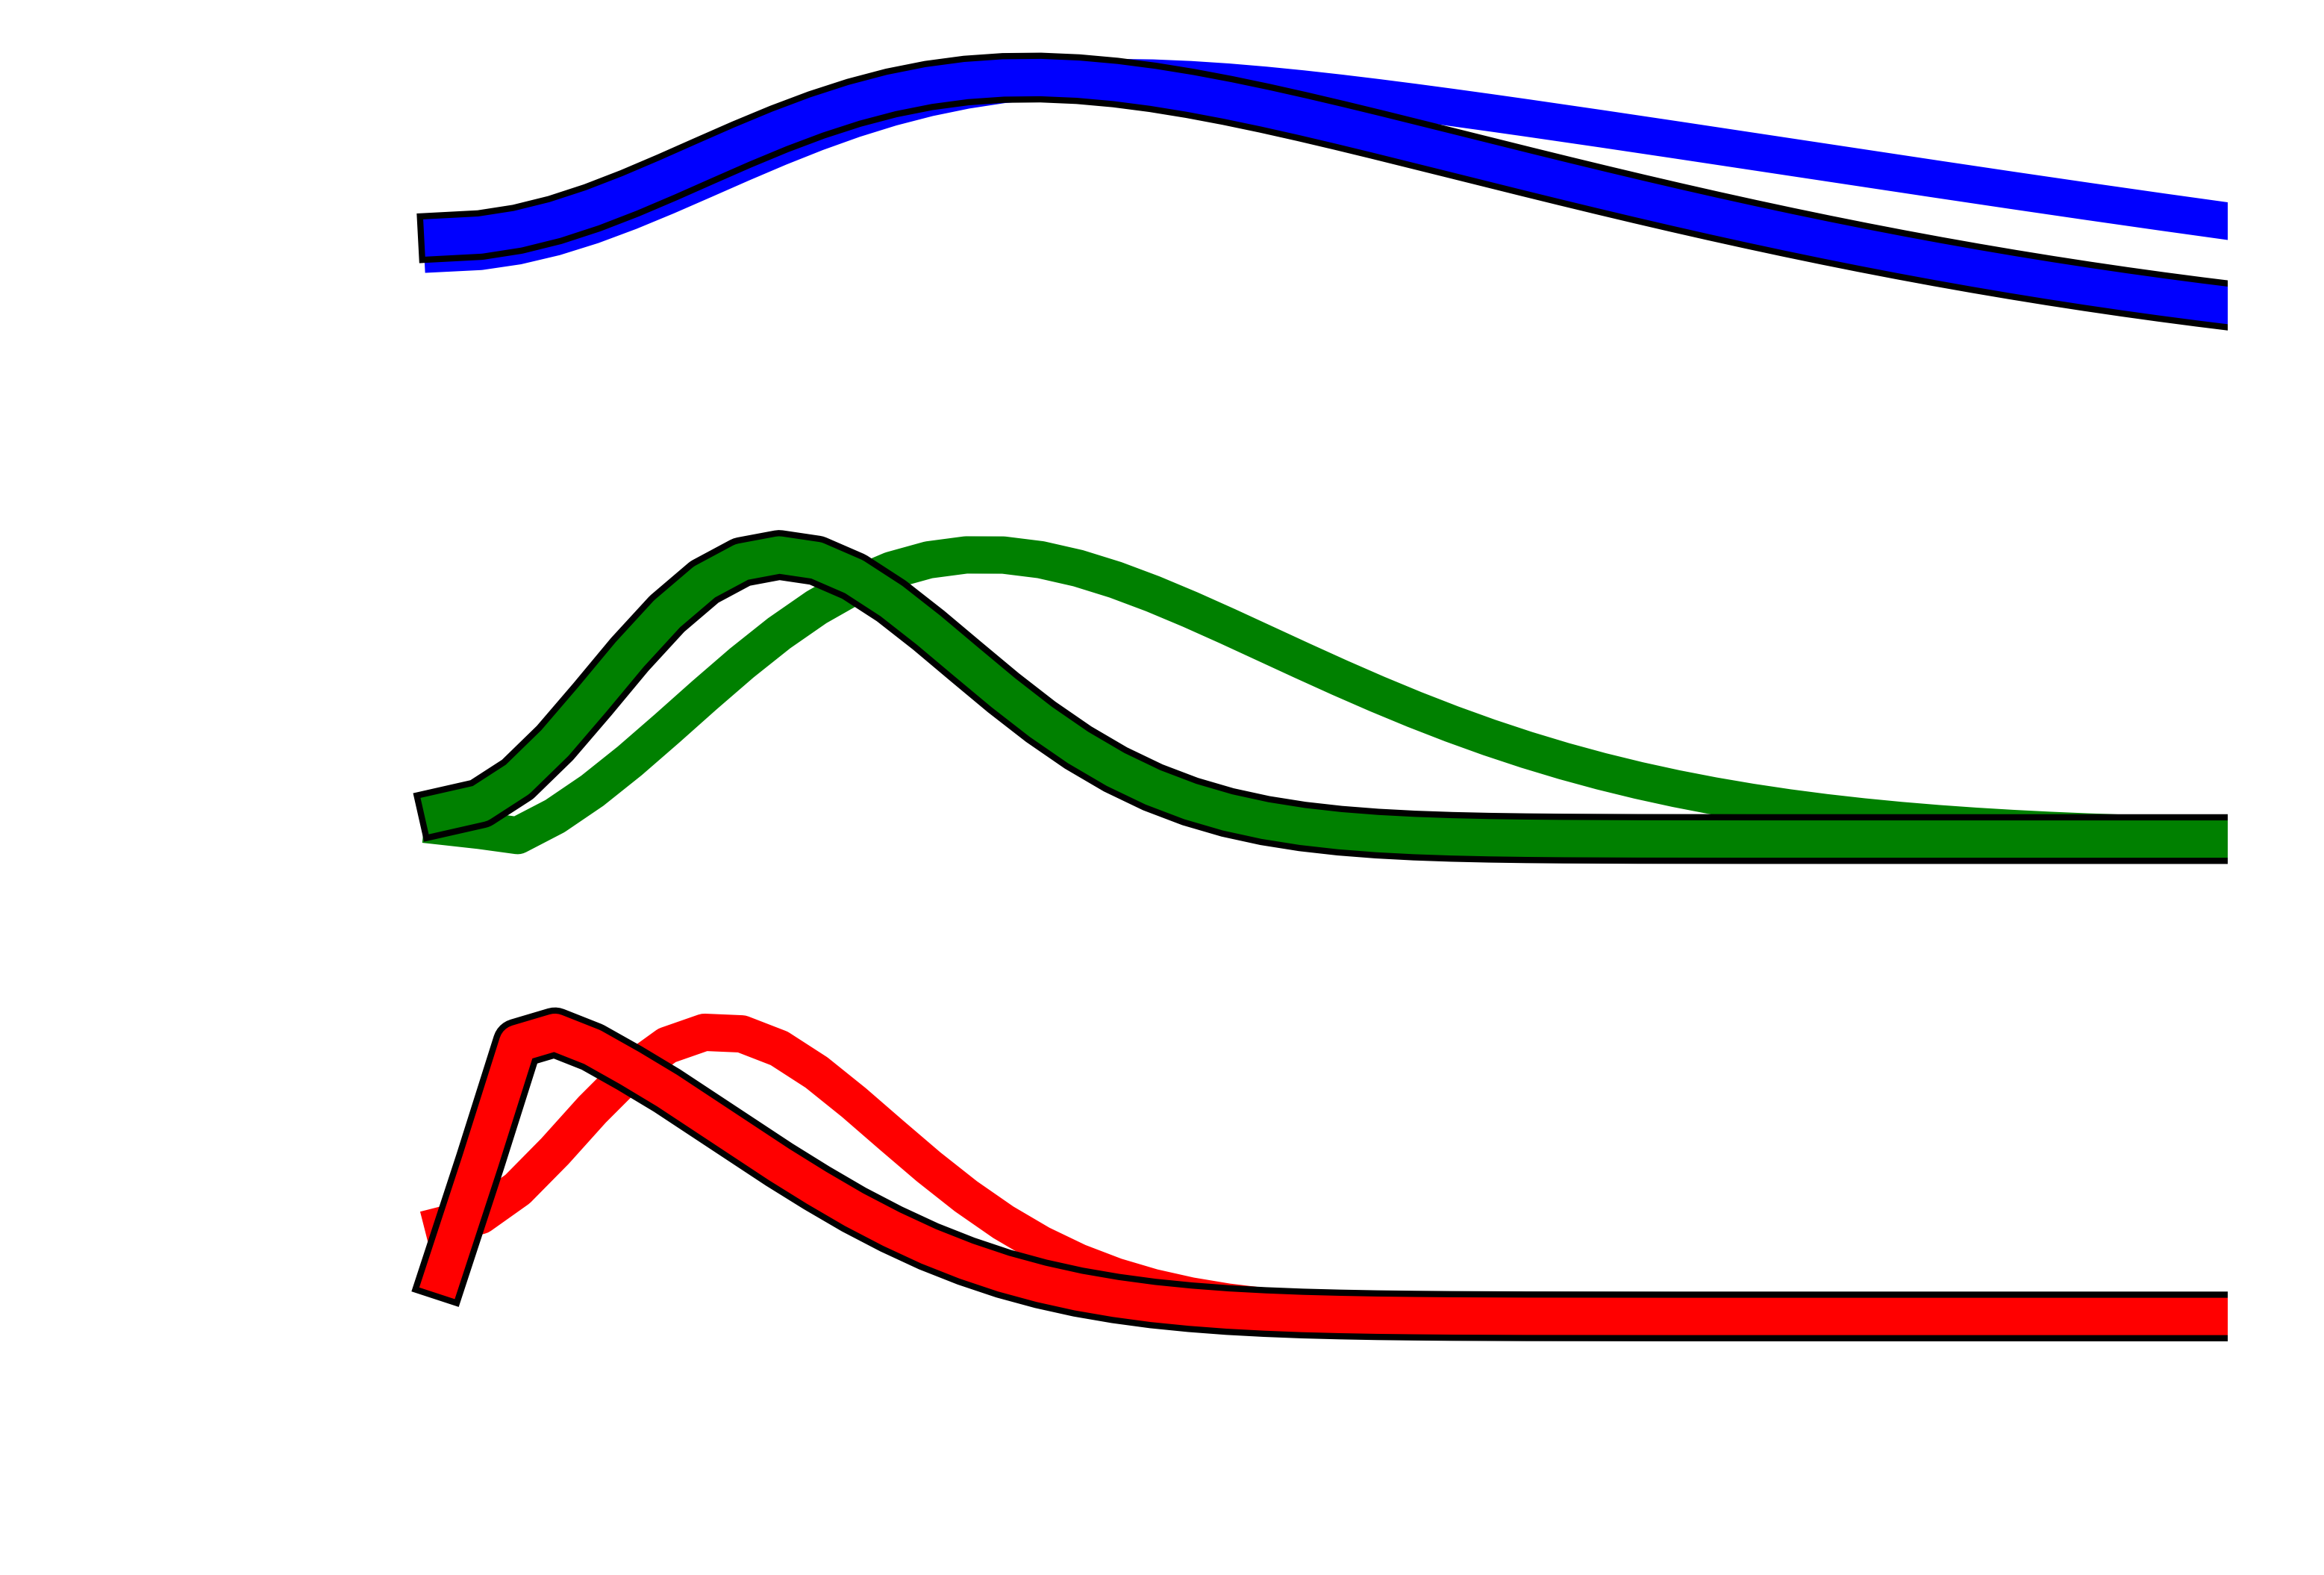

In [151]:
extreme_rfs = collections.defaultdict(list)
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for exi, (idw1, idw2) in enumerate(example_ids):
    w1 = widths[idw1]
    w2 = widths[idw2]
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    surround2 = gaussian(x=space, sigma=w2, mu=0.)
    surround2 /= np.sum(surround2)

    def rf_model(horz_weight, center_weight):
        return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

    this_map = infos_varying_width[(w1,w2)]
    which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
    hw = horz_weights[which_fft[0]]
    cw = center_weights[which_fft[1]]

    mean_info = np.mean(infos_varying_width[(w1,w2)][:, which_fft[1]])

    all_h_rf = rf_model(horz_weights[-1], cw)
    all_a_rf = rf_model(horz_weights[0], cw)

    all_h_fft = abs(np.fft.rfft(all_h_rf))
    all_a_fft = abs(np.fft.rfft(all_a_rf))

    # Plot the two RFs
    plt.subplot('31%d' %(exi+1))
    plt.plot(freqs, all_a_fft/np.max(abs(all_a_fft)), color=colors[exi], linewidth=6)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color='k', linewidth=8)
    plt.plot(freqs, all_h_fft/np.max(abs(all_h_fft)), color=colors[exi], linewidth=6)
    plt.axis('off')
    plt.ylim(-.3, 1.1)
    plt.xlim(-.1, .6)
#     plt.title('Diversity %0.2f$^\circ$ -  Information loss %0.1f%%' %(this_angle_fft, 100*(1 - this_info)), 
#               fontsize=18)
#     adjust_spines(plt.gca())
# plt.savefig('4-2 extreme RFs.png', transparent=True)

In [154]:
from scipy.signal import convolve2d

In [155]:
# contour
samples = np.random.multivariate_normal([0,0], np.eye(2), (1000000))
angle_bins = radians_to_deg * np.linspace(0, 1.4, 180)
info_bins = np.linspace(1.5, 80, 180)
count_2d, angles_edges, info_edges = np.histogram2d(radians_to_deg * np.array(angles_fft_data),
                                                   100*(1 - np.array(info_difference_data)),
                                                   bins=[angle_bins, info_bins])
gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-5,5,30), normed=True)
smoothed_count_2d = convolve2d(count_2d, gauss_2d**2, mode='same')
smoothed_count_2d[:,0] = 0

(1.7, 60)

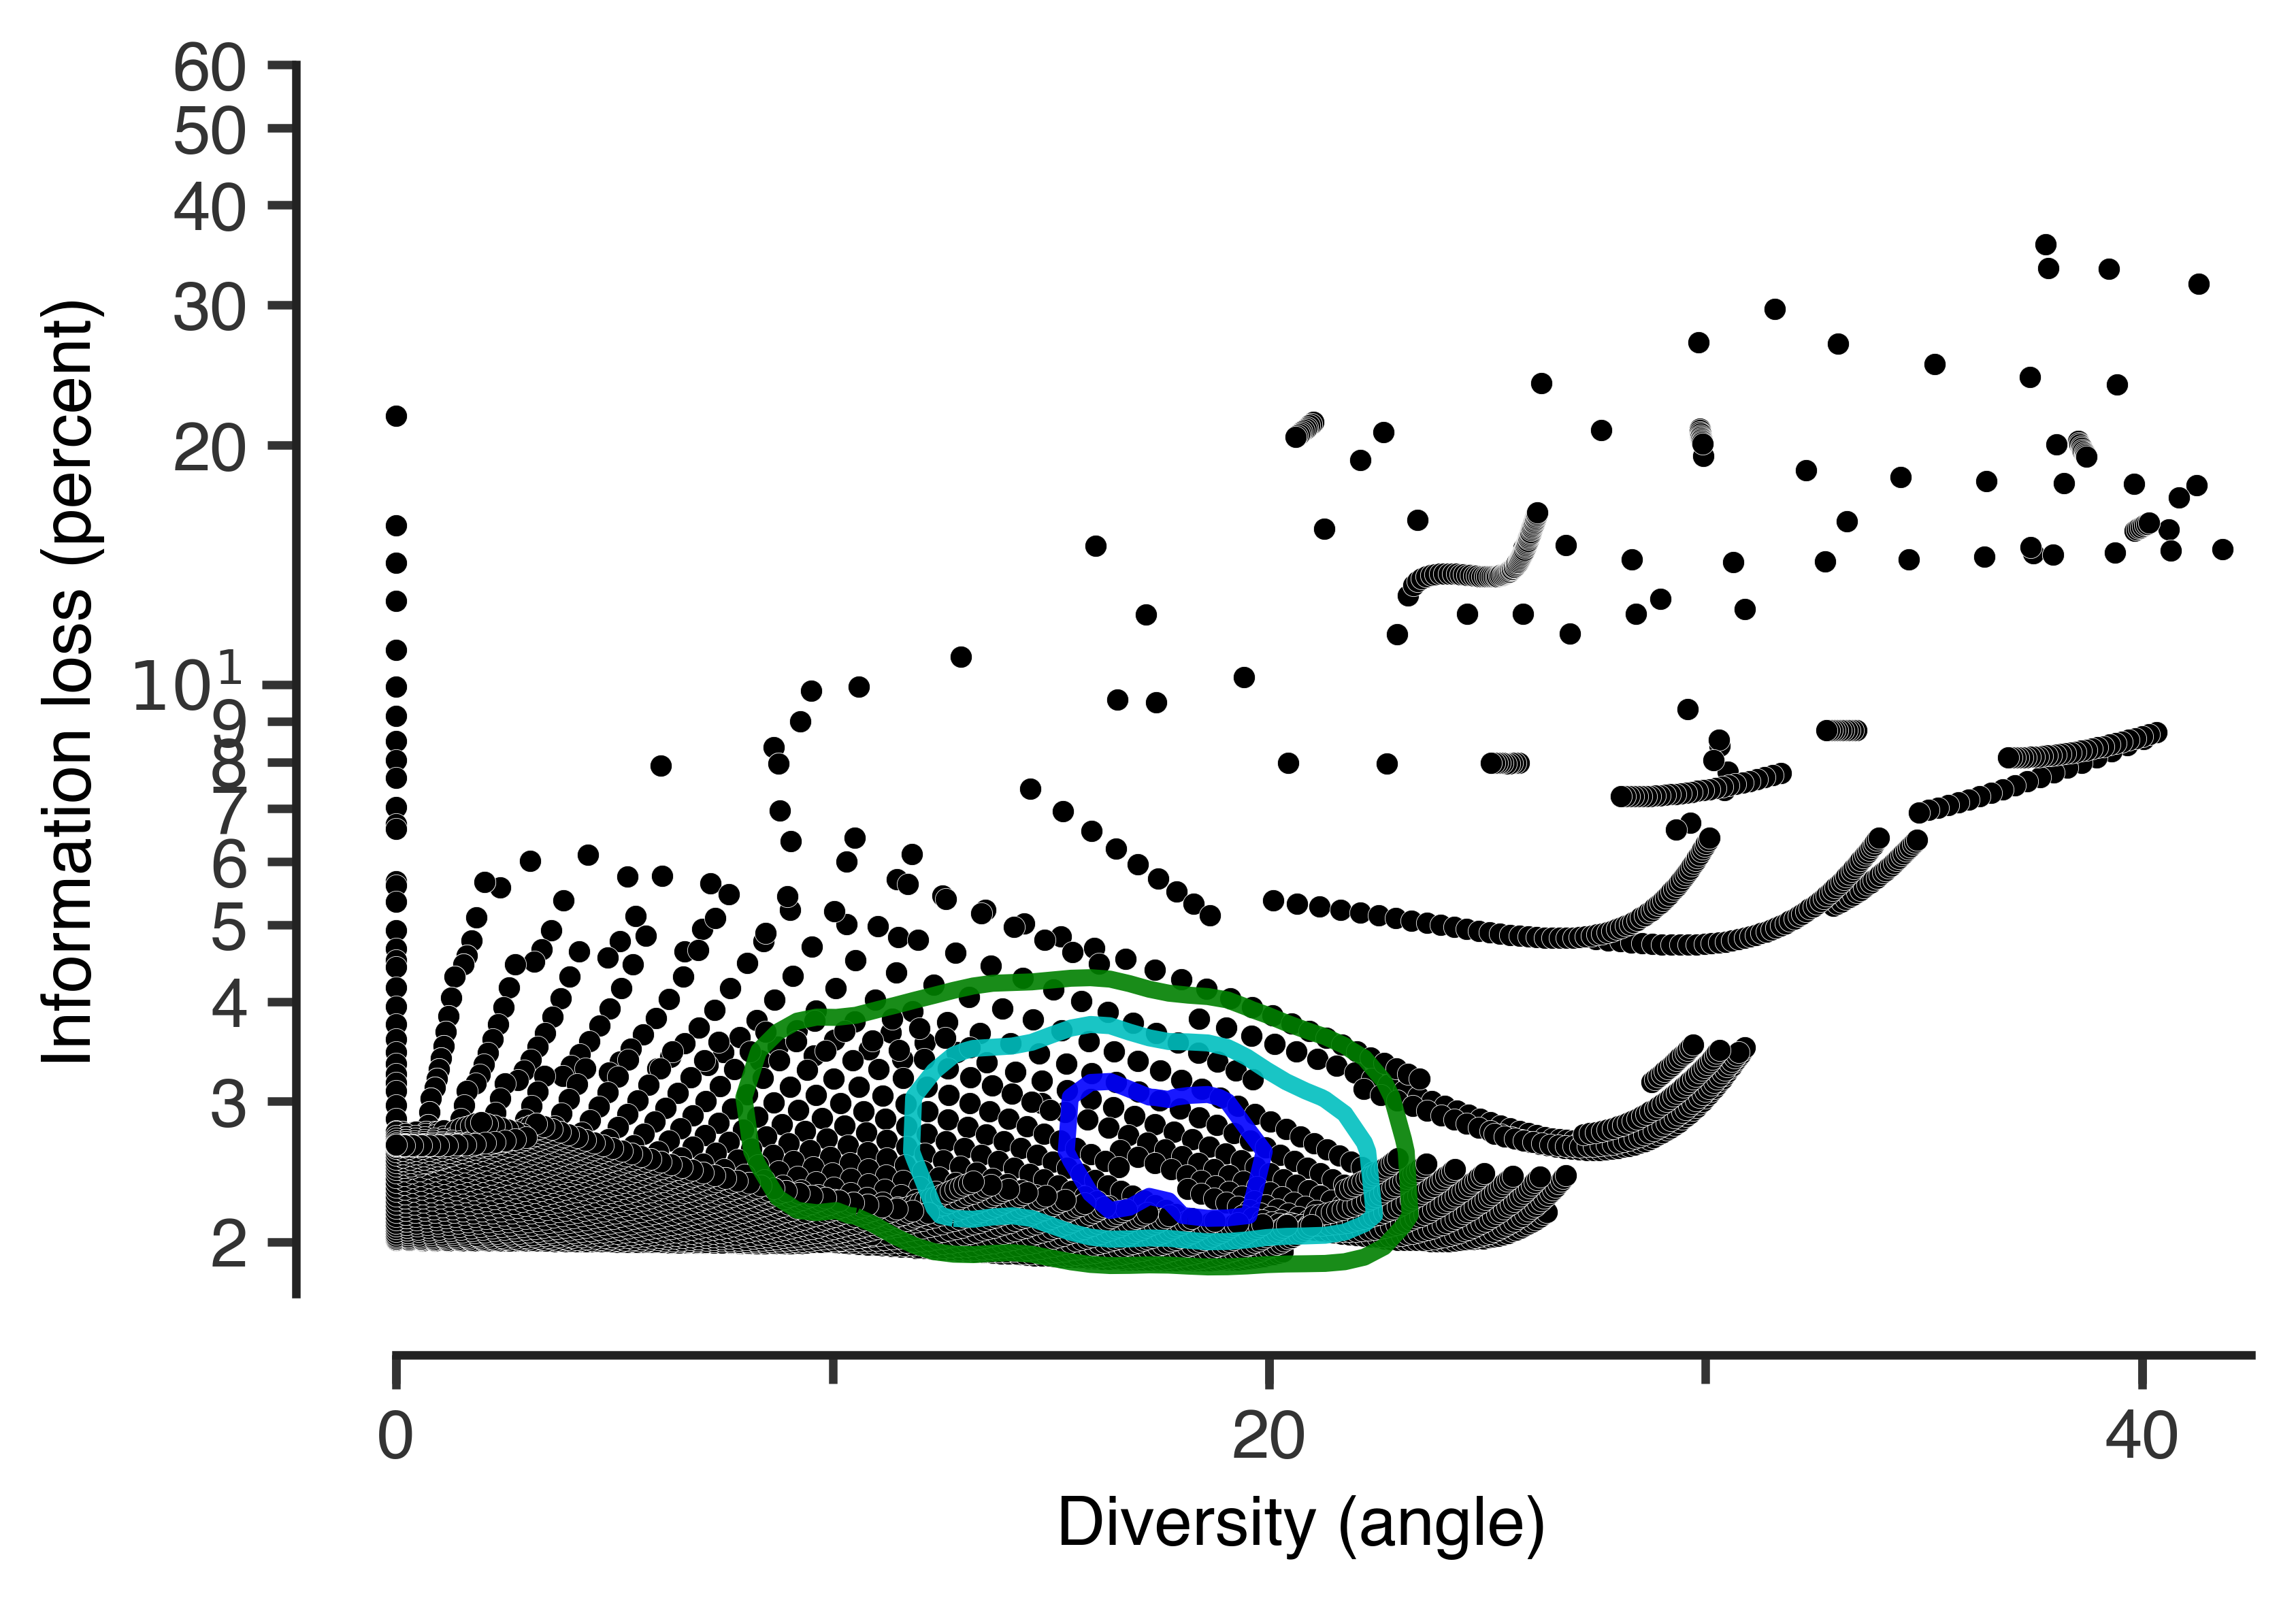

In [156]:
eps = 10e-10
plt.scatter(radians_to_deg*angles_fft_opposite_edges, 100*(1 - info_difference_opposite_edges.ravel()) + eps, color='k', edgecolor='w', linewidth=0.1, s=15)
# plt.scatter(radians_to_deg*np.array(all_arccos),
#             100*(1 - np.array(all_info_losses)) + eps, color='k', edgecolor='w', linewidth=0.1, s=15)

# contour
angle_bins = radians_to_deg * np.linspace(0, 1.4, 180)
info_bins = np.linspace(1.5, 80, 180)
count_2d, angles_edges, info_edges = np.histogram2d(radians_to_deg * np.array(angles_fft_data),
                                                   100*(1 - np.array(info_difference_data)),
                                                   bins=[angle_bins, info_bins])

# for exi, (idw1, idw2) in enumerate(example_ids):
#     plt.scatter(example_angles[exi], example_info_loss[exi], color=colors[exi], linewidth=0.1, s=15)
# gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-5,5,30), normed=True)
# smoothed_count_2d = convolve2d(count_2d, gauss_2d**2, mode='same')
# smoothed_count_2d[:,0] = 0

contour_colors = ['g', 'c', 'b']
X, Y = np.meshgrid(angles_edges[:-1] + np.mean(np.diff(angles_edges))/2, 
                   info_edges[:-1] + np.mean(np.diff(info_edges))/2)
CS = plt.contour(X, Y, smoothed_count_2d.T, 3, linewidths=3, alpha=0.9, colors=contour_colors)
# contour_counts = CS.levels
# for i,c in enumerate(contour_counts):
#     plt.text(0.8, 5-1.5*i/2, '%d interneuron cell pairs' %c, fontsize=9, color=contour_colors[i])

majorLocator = MultipleLocator(20)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(10)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)


plt.xlabel('Diversity (angle)')
plt.ylabel('Information loss (percent)')
adjust_spines(plt.gca())
plt.yscale('log')
# plt.ylim(10e-3,80)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().labelOnlyBase = False
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.f"))
plt.xlim(-1, 42.5)
plt.ylim(1.7, 60)
# plt.savefig('12-2 information loss vs diversity with data contour with coarse-grained widths.pdf')
# plt.savefig('4-2 information loss vs diversity with contours without extreme rfs.pdf')

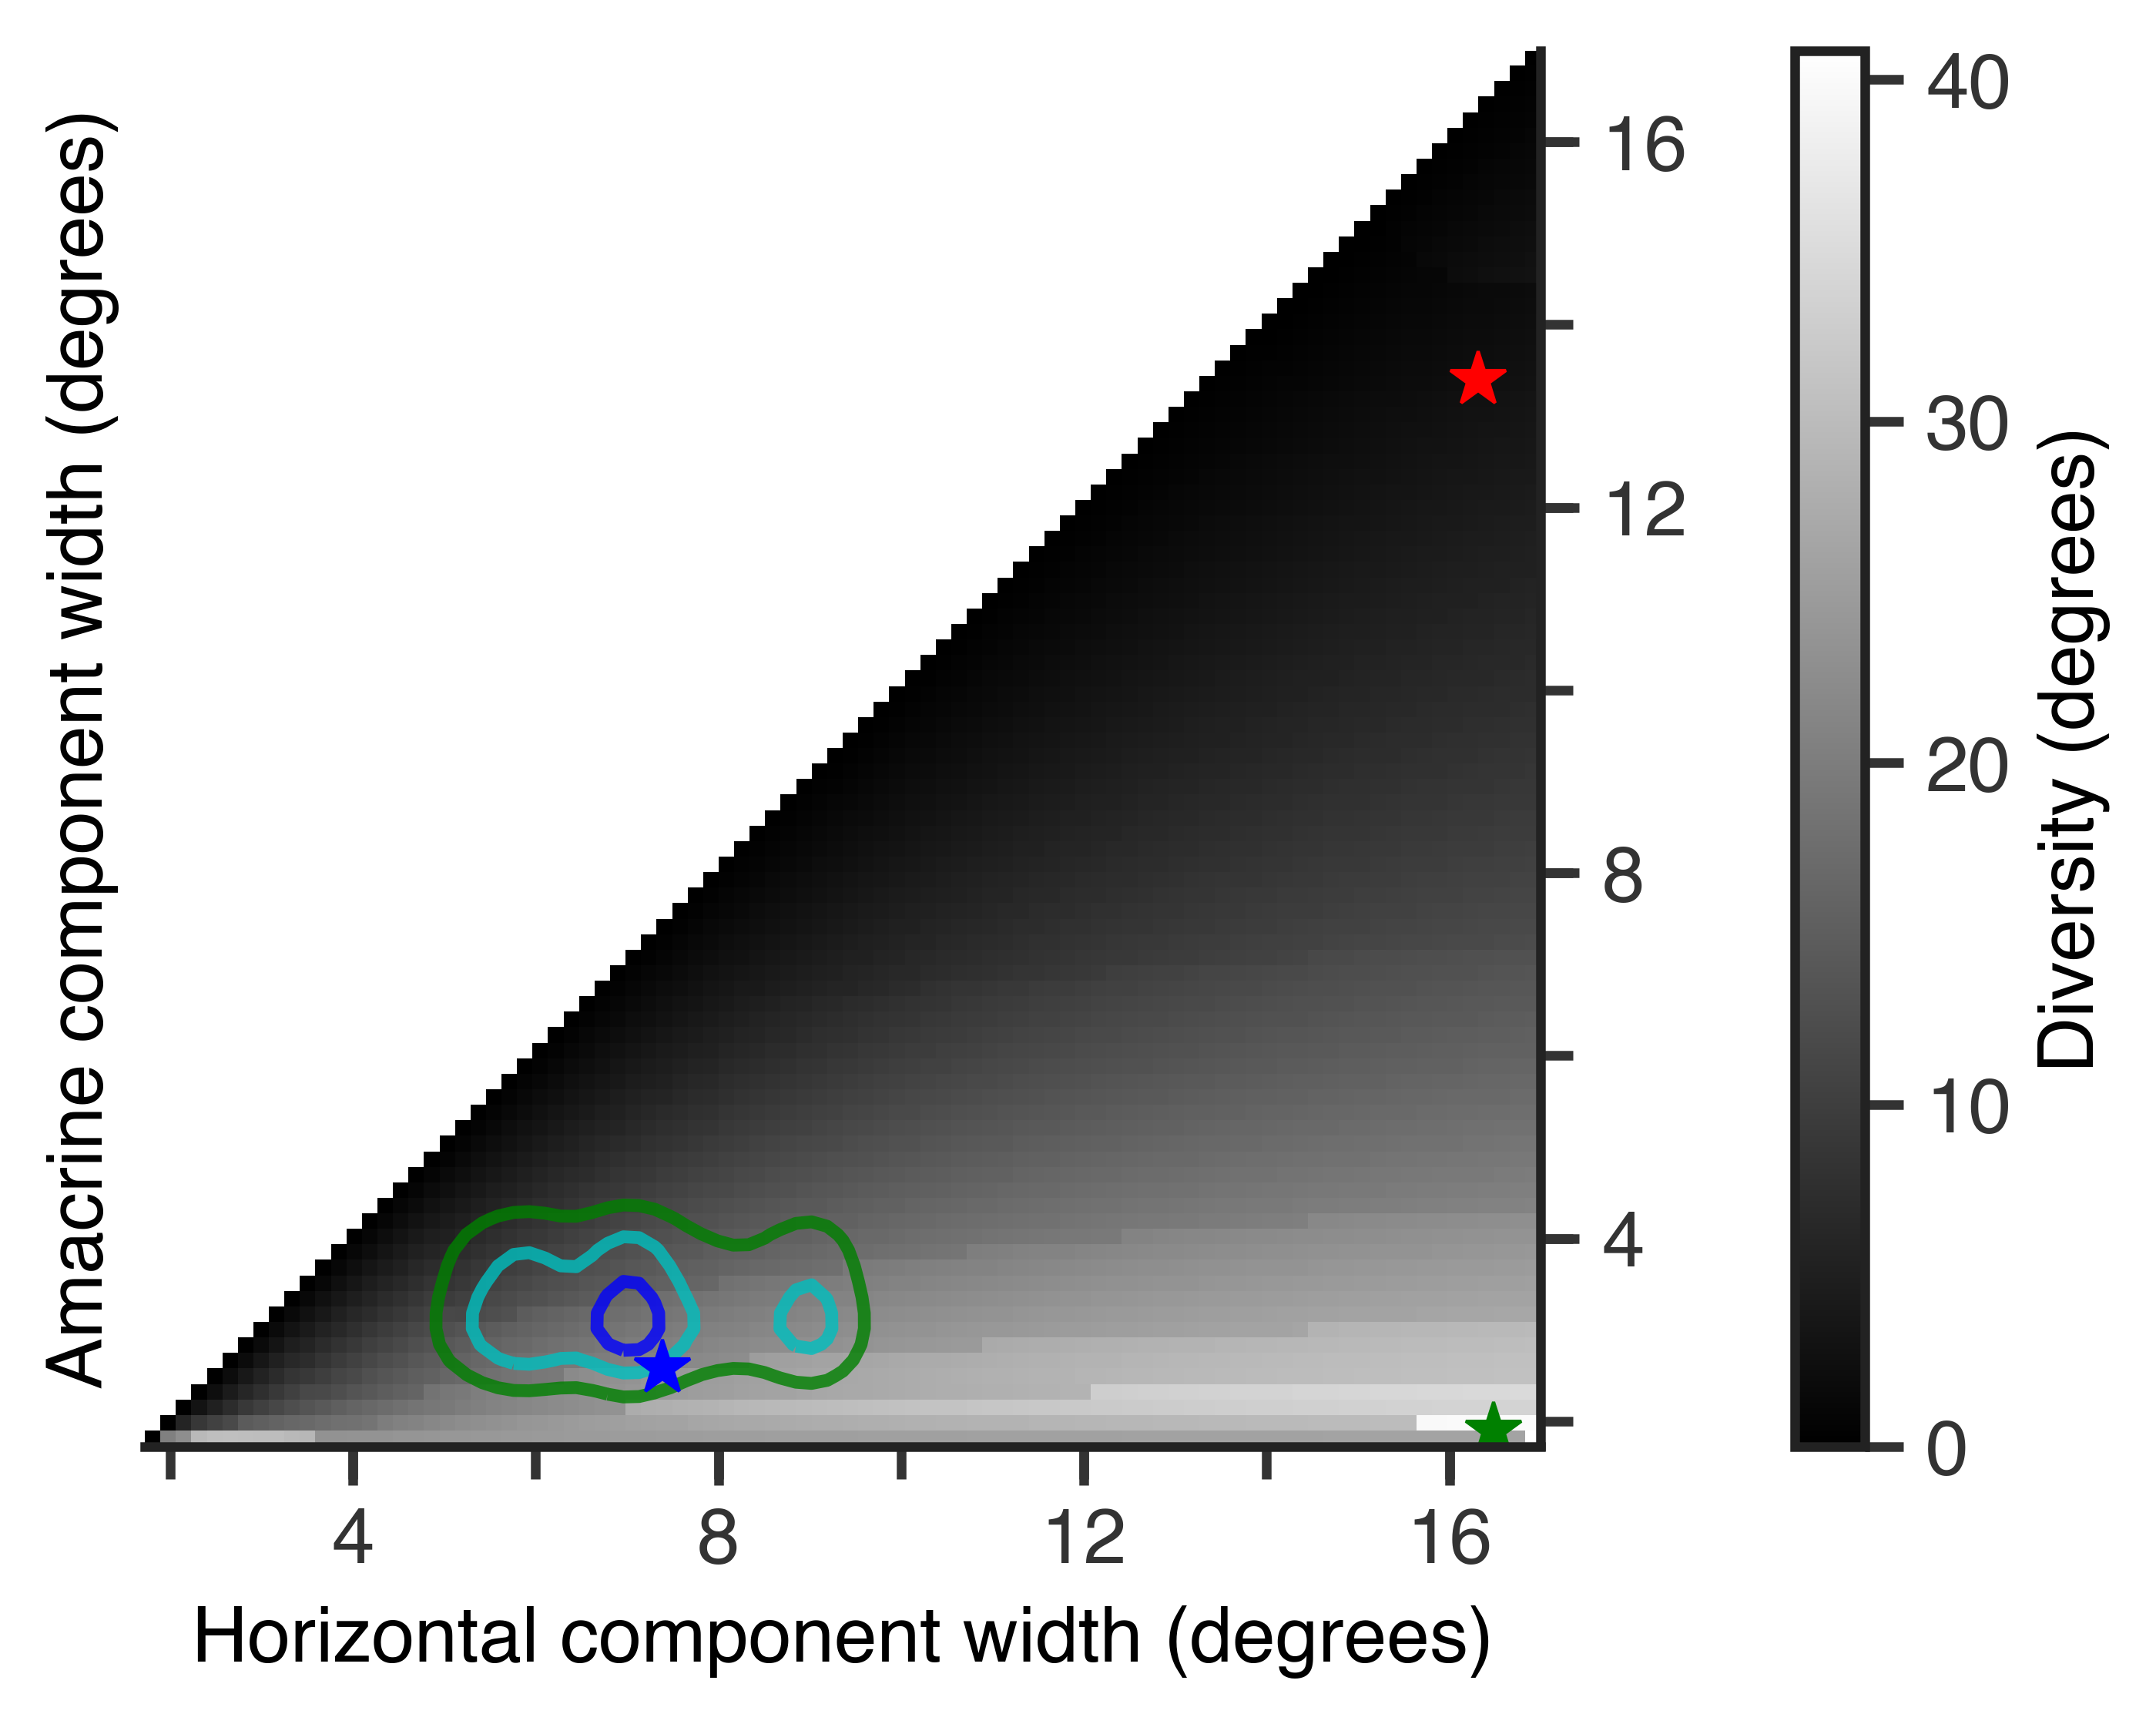

In [162]:
example_indices = [[43, 15], 
                   [96, 11], 
                   [95, 78]]

half_angles_fft = np.copy(angles_fft_opposite_edges)
for i in range(angles_fft_opposite_edges.shape[0]):
    for j in range(i+1, angles_fft_opposite_edges.shape[1]):
        half_angles_fft[j,i] = 1
        

samples = np.random.multivariate_normal([0,0], np.eye(2), (1000000))
gauss_2d, bins_x, bins_y = np.histogram2d(samples[:,0], samples[:,1], np.linspace(-4,4,20), normed=True) 
smoothed_interneuron_pairs = convolve2d(interneuron_pairs, gauss_2d, mode='same')

starting_width_idx = 10
ax = plt.gca()
im = plt.imshow(radians_to_deg*half_angles_fft[starting_width_idx:, starting_width_idx:], origin='bottom left', 
                extent=[widths[starting_width_idx], widths[-1], widths[starting_width_idx], widths[-1]],
               clim=[0, np.max(np.tril(radians_to_deg*half_angles_fft[starting_width_idx:, starting_width_idx:].T, k=-1))])
# plt.title('angle between horz only \n and ama only ffts', fontsize=9)
plt.xlim(widths[starting_width_idx], widths[-1])
plt.ylim(widths[starting_width_idx], widths[-1])
plt.xlabel('Horizontal component width (degrees)')

colors = ['b', 'g', 'r']
for exi,ex in enumerate(example_indices):
    plt.plot(widths[ex[0]], widths[ex[1]], colors[exi], marker='*', markersize=9, alpha=1)

# contour
contour_colors = ['g', 'c', 'b']
bar_width = np.mean(np.diff(horz_edges))
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
CS = plt.contour(X, Y, smoothed_interneuron_pairs.T, 3, linewidths=2, alpha=0.8, colors=contour_colors)


majorLocator = MultipleLocator(4)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(2)

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

# axes
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')
plt.ylabel('Amacrine component width (degrees)')
divider = make_axes_locatable(ax)
cax2 = divider.append_axes("right", size="5%", pad=0.55)
cbar = plt.colorbar(im, cax=cax2)
cbar.ax.set_ylabel('Diversity (degrees)', fontsize=12)
cbar.set_ticks([0, 10, 20, 30, 40])

# plt.savefig('lower triangle of diversity smoothed contours with examples degrees 4-2.png', transparent=True)